# BTW 2025 Data Science Challenge

## Introduction 
Forecasting market influences, supply, demand, and ultimately prices is of paramount importance for any entity operating within a market. 
This is particularly salient in the context of the electricity market, where the stability of the grid is contingent upon the precarious equilibrium of supply and demand, with any disruption to this balance having the potential to severely impact the grid's reliability.
Consequently, the field of electricity price forecasting stands as a subject of considerable relevance for both market participants and academic researchers.
Historically, these predictions have relied on statistical methods, as exemplified by Conteras et al. (2003) using ARIMA models to predict next day's prices or Nunes et al. (2008) using SARIMA and GARCH models with moving averages. 
In recent years, machine learning has become a prominent feature of these attempts. An illustration of this phenomenon can be found in the works of Lago et al. (2018), who reported substantial success in employing deep learning in comparison to conventional statistical methodologies when predicting the next days prices. 
Another recent example proving the merit of machine learning in electricity price forecasting was achieved by Tschora et al. (2022). In their research they evaluated several machine learning approaches and achieved state-of-the-art results. Furthermore, they were able to illustrate the impact of specific influences of the final price using xAI, enabling an informed selection of features and input data for price prediction. 

Inspired by the BTW 2025 Data Science Challenge and many such pioneers, the following report details the work of the Dresden group over the last semester, attempting to forecast the day-ahead-price via a large range of methods to forecast time series.
These methods encompass a wide spectrum, ranging from xAI integrated with conventional forecasting techniques such as ARIMA and ETS, to advanced models including (X)LSTM and transformer-based models, culminating in highly optimized approaches enabled by AutoML, exemplified by AutoGluon. 
Nevertheless, it is imperative to acknowledge that no single approach can attain results that surpass the quality of the input data. The following work therefore also details the groups work in collecting, preparing and analyzing data pertaining to the German electricity prices. 

## Utils


In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121



In [ ]:

# TODO Load Data
# TODO Base Model Class
"""
Base model structure.
Every Forecasting model should inherit from this.

Note: override all abstract methods and keep the final methods unchanged
"""
import pandas as pd
from abc import ABC, abstractmethod
from typing import final
import pandas as pd
from autogluon.tabular import TabularPredictor
import pickle
import os
import torch
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from chronos import ChronosPipeline


class BaseModel(ABC):

    def __init__(self, model_name: str, model_type: str):
        """Init and create model.

        :param model_name: Name of your model
        :param model_type: Type of your model e.g. LSTM
        """
        self.model_name = model_name
        self.model_type = model_type
        self.model = None  # this is a placeholder for your model
        self.__create_model()

    @abstractmethod
    def __create_model(self):
        """Define your own model under self.model.
        """
        ...

    @abstractmethod
    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame,
              X_val: pd.DataFrame = None, y_val: pd.DataFrame = None,
              X_test: pd.DataFrame = None, y_test: pd.DataFrame = None) -> pd.DataFrame | None:
        """train the model on the training data.
        test and validation data can be used only for evaluation (if available).

        :param X_train: training features dataset
        :param y_train: training target values
        :param X_val: validation features' dataset
        :param y_val: validation target values
        :param X_test: testing features' dataset
        :param y_test: testing target values
        :return: training history (losses while training, if available else None) [epoch | train_loss | test_loss]
        """
        # call the training loop/function of your model
        # and return a history (if available, otherwise None)
        ...

    @abstractmethod
    def __run_prediction(self, X: pd.DataFrame) -> pd.DataFrame:
        """run prediction on your defined model

        :param X: features dataset
        :return: prediction output, [timestamp | value]
        """
        ...

    @final
    def predict(self, X: pd.DataFrame, exp_dir: str = None) -> pd.DataFrame:
        """call this to run prediction

        :param X: features dataset
        :param exp_dir: dir to store prediction result
        :return: prediction output, [timestamp | value]
        """
        # run your custom prediction
        prediction_results = self.__run_prediction(X)

        # store if dir is provided
        if exp_dir is not None:
            prediction_results.to_csv(f'{exp_dir}\\{self.model_type}_{self.model_name}_prediction.csv')
        return prediction_results

    @abstractmethod
    def __custom_save(self, model: object, filename: str):
        """Use your own dataformat to save your model here

        :param filename: filename or path
        """
        ...

    @abstractmethod
    def __custom_load(self, filename: str) -> object:
        """Use your own dataformat to load your model here

        :param filename: filename or path
        :return: your loaded model
        """
        # return model
        ...

    @final
    def save(self, exp_dir: str):
        """call this to save self.model.

        :param exp_dir: dir name or path to dir
        """
        self.__custom_save(model=self.model, filename=f'{exp_dir}\\{self.model_type}_{self.model_name}')

    @final
    def load(self, exp_dir: str):
        """call this to load a retrained model

        :param exp_dir: dir name or path to dir
        """
        self.model = self.__custom_load(filename=f'{exp_dir}\\{self.model_type}_{self.model_name}')


# TODO All Models

class ChronosModel(BaseModel):
    def __init__(self, model_name: str, model_type: str):
        """Call the BaseModel constructor with the required arguments."""
        super().__init__(model_name, model_type)

    def _BaseModel__create_model(self):
        self.model = None

    
    def _BaseModel__run_prediction(self, X):

        #define which column to be forecasted and forecast legth
        target_column = "day_ahead_prices_EURO"
        prediction_length = 24

        
        context = torch.tensor(X[target_column].values)[-512:]  # Limit context to last 512 samples
        forecast = self.model.predict(context, prediction_length)
        low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

        context_dates = X.index[-512:]
        last_date = context_dates[-1]
        forecast_index = pd.date_range(last_date + pd.Timedelta(hours=1), periods=prediction_length, freq="H")

        prediction_results = pd.DataFrame({
            "timestamp": forecast_index,
            "forecasted_values": median
        })
        
        return prediction_results

    
    def _BaseModel__custom_load(self, model_dir):
        
        # Load the model pipeline
        pipeline = ChronosPipeline.from_pretrained(
            model_dir,
            device_map=("cuda" if torch.cuda.is_available() else "cpu"),
            torch_dtype=torch.bfloat16,
        )
        self.model = pipeline  # Set the model to the loaded pipeline

        return pipeline
    
    
                
    def _BaseModel__custom_save(self, model = None, filename = None):
        return

    def train(self, X_train = None, y_train = None, X_val = None, y_val = None, X_test = None, y_test = None):
        return None
        

class NewsEmbeddingModel(BaseModel):
    def __init__(self, model_name: str):
        """Initialize the AutoGluon model wrapper"""
        super().__init__(model_name=model_name, model_type="AutoGluon")
        
    def _BaseModel__create_model(self):
        """Initialize an empty TabularPredictor"""
        self.model = None  # Will be loaded from pickle
        
    def _BaseModel__run_prediction(self, X: pd.DataFrame) -> pd.DataFrame:
        """Run prediction using the loaded AutoGluon model
        
        Args:
            X (pd.DataFrame): Input features
            
        Returns:
            pd.DataFrame: Predictions with timestamp and value columns
        """
        # Make predictions
        predictions = self.model.predict(X)
        
        # Create results DataFrame
        results = pd.DataFrame({
            'timestamp': X.index if isinstance(X.index, pd.DatetimeIndex) else X.index.values,
            'value': predictions
        })
        
        return results
    
    def _BaseModel__custom_save(self, model: TabularPredictor, filename: str):
        """Save the AutoGluon model using pickle
        
        Args:
            model: The AutoGluon TabularPredictor instance
            filename: Path where to save the model
        """
        with open(f"{filename}.pkl", 'wb') as f:
            pickle.dump(model, f)
    
    def _BaseModel__custom_load(self, filename: str) -> TabularPredictor:
        """Load the AutoGluon model from pickle
        
        Args:
            filename: Path to the saved model
            
        Returns:
            The loaded TabularPredictor instance
        """
        with open(f"{filename}.pkl", 'rb') as f:
            return pickle.load(f)
    
    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame,
              X_val: pd.DataFrame = None, y_val: pd.DataFrame = None,
              X_test: pd.DataFrame = None, y_test: pd.DataFrame = None) -> pd.DataFrame:
        """Train the AutoGluon model
        
        Note: This implementation assumes you're using a pre-trained model
        and will raise an error if called
        
        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features
            y_val: Validation targets
            X_test: Test features
            y_test: Test targets
            
        Returns:
            None as we're using a pre-trained model
        """
        raise NotImplementedError(
            "This implementation uses a pre-trained AutoGluon model. "
            "Please use the trained model.pkl file instead of training a new model."
        )

class ETSModel(BaseModel):
    def _BaseModel__create_model(self):
        self.model = None

    def train(self, X_train, y_train, X_val = None, y_val = None, X_test = None, y_test = None):
        #time_series = X_train
        if y_train.isnull().any():
            print("Warning: Missing values in y_train are being automatically filled by the ETSModel.")
            y_train = y_train.ffill()
        model = ExponentialSmoothing(y_train, seasonal_periods=24, trend="add", seasonal="add")
        self.model = model.fit()
        return None
    
    def _BaseModel__run_prediction(self, X):
        if self.model is None:
            raise ValueError("The model is not trained. Call `train` before prediction.")
        forecast = self.model.forecast(len(X))
        #print(forecast)
        #print(X)
        prediction_results = pd.DataFrame({
            'timestamp': X['Date'],  # Use the 'Date' column in X for timestamps
            'value': forecast.values
        })
        return prediction_results

    def _BaseModel__custom_save(self, model, filename):
         with open(f"{filename}.pkl", "wb") as file:
            pickle.dump(model, file)
    
    def _BaseModel__custom_load(self, filename):
        with open(f"{filename}.pkl", "rb") as file:
            loaded_model = pickle.load(file)
        return loaded_model
    




In [1]:
class BenchmarkMaker:
    def __init__(self, export_dir):
        self.export_dir = export_dir  # output for plots and benchmark .csv files

        if not os.path.exists(self.export_dir):
            # create the directory in case it does not already exist
            os.makedirs(self.export_dir)

        # load input data
        self.data = None
        self.model_names = []

    def load_dataframes(self, predictions: dict, prices: pd.DataFrame):
        """loading datasets of predictions from different models

        :param predictions: dict form: {model_name1: df1, model_name2: df2, ...}
        :param prices: ground truth prices dataframe
        """
        for k in predictions.keys():
            predictions[k] = predictions[k].set_axis([str(k)], axis='columns')
            self.model_names.append(str(k))
        prices = prices.set_axis(['day_ahead_prices'], axis='columns')
        self.align_dataframes(list(predictions.values()) + [prices])

    def align_dataframes(self, dataframes):
        """Align multiple DataFrames with timestamp indices by merging them on their index.
        """
        result_df = dataframes[0]
        for df in dataframes[1:]:
            result_df = result_df.join(df, how='outer')
        self.data = result_df

    def calc_errors(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values
        for pred_model in self.model_names:
            pred_values = no_nan[pred_model].values
            self.data[str(pred_model) + '_RMSE'] = self.calc_rmse(gt_values, pred_values)
            self.data[str(pred_model) + '_MAE'] = self.calc_mae(gt_values, pred_values)
            self.data[str(pred_model) + '_MAPE'] = self.calc_mape(gt_values, pred_values)
            self.data[str(pred_model) + '_SE'] = self.calc_squared_error(self.data['day_ahead_prices'].values,
                                                                         self.data[pred_model].values)
            self.data[str(pred_model) + '_AE'] = self.calc_absolute_error(self.data['day_ahead_prices'].values,
                                                                          self.data[pred_model].values)

    def calc_squared_error(self, actual_values, predicted_values):
        se = (actual_values - predicted_values)**2
        return se

    def calc_absolute_error(self, actual_values, predicted_values):
        ae = abs(actual_values - predicted_values)
        return ae

    def calc_rmse(self, actual_values, predicted_values):
        mse = mean_squared_error(actual_values, predicted_values)
        rmse = np.sqrt(mse)
        return rmse

    def calc_mae(self, actual_values, predicted_values):
        mae = mean_absolute_error(actual_values, predicted_values)
        return mae

    def calc_mape(self, actual_values: np.ndarray, predicted_values: np.ndarray) -> float:
        """calculate mean average percentage error.
        close to 0: good
        close to 1: bad

        :param actual_values: correct underlying values
        :param predicted_values: forecasted values
        :return: mape"""
        mape = mean_absolute_percentage_error(actual_values, predicted_values)
        return mape

    def plot_rmse_per_hour(self):
        for model in self.model_names:
            plt.plot(self.data.index.values, np.sqrt(self.data[model + '_SE'].values), label=model)
        plt.xticks(rotation=45)
        plt.title('RMSE per Hour')
        plt.xlabel('Timestamp')
        plt.ylabel('RMSE')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'hourly_rmse.png')
        plt.show(block=True)

    def plot_mae_per_hour(self):
        for model in self.model_names:
            plt.plot(self.data.index.values, self.data[model + '_AE'].values, label=model)
        plt.xticks(rotation=45)
        plt.title('Absolute Error per Hour')
        plt.xlabel('Timestamp')
        plt.ylabel('Absolute Error')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'hourly_mae.png')
        plt.show(block=True)

    def plot_rmse_per_day(self):
        copy_df = self.data.reset_index(names='timestamp')
        for model in self.model_names:
            days_df = copy_df.groupby(copy_df.timestamp.dt.date).mean().reset_index(names='date')
            plt.plot(days_df['timestamp'], np.sqrt(days_df[model + '_SE']), label=model)
        plt.xticks(rotation=45)
        plt.title('RMSE per Day')
        plt.xlabel('Timestamp')
        plt.ylabel('RMSE')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'daily_rmse.png')
        plt.show(block=True)

    def plot_mae_per_day(self):
        copy_df = self.data.reset_index(names='timestamp')
        for model in self.model_names:
            days_df = copy_df.groupby(copy_df.timestamp.dt.date).mean().reset_index(names='date')
            plt.plot(days_df['timestamp'], np.sqrt(days_df[model + '_AE']), label=model)
        plt.xticks(rotation=45)
        plt.title('MAE per Day')
        plt.xlabel('Timestamp')
        plt.ylabel('MAE')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'daily_mae.png')
        plt.show(block=True)

    def plot_compare_predictions_hourly(self):
        gt_values = self.data['day_ahead_prices'].values
        timestamps = self.data.index.values
        plt.plot(timestamps, gt_values, label='Actual Values')

        for model in self.model_names:
            pred_values = self.data[model].values
            plt.plot(timestamps, pred_values, label=model)

        plt.xticks(rotation=45)
        plt.title('Model Predictions per Hour')
        plt.ylabel('Day Ahead Price in €')
        plt.xlabel('Timestamp')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'hourly_compare_predictions.png')
        plt.show(block=True)

    def plot_compare_predictions_daily(self):
        copy_df = self.data.reset_index(names='timestamp')
        days_df = copy_df.groupby(copy_df.timestamp.dt.date).mean().reset_index(
            names='date')
        timestamps = days_df['timestamp'].values

        gt_values = days_df['day_ahead_prices'].values
        plt.plot(timestamps, gt_values, label='Actual Values')

        for model in self.model_names:
            pred_values = days_df[model].values
            plt.plot(timestamps, pred_values, label=model)

        plt.xticks(rotation=45)
        plt.title('Model Predictions per Day')
        plt.ylabel('Day Ahead Price in €')
        plt.xlabel('Timestamp')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'daily_compare_predictions.png')
        plt.show(block=True)

    def plot_compare_mae(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values

        mae_values = []
        for model in self.model_names:
            pred_values = no_nan[model].values
            mae = self.calc_mae(gt_values, pred_values)
            mae_values.append(mae)
        x = np.arange(len(self.model_names))

        ax = plt.subplot(111)
        my_cmap = plt.get_cmap("jet")
        colors = my_cmap(np.linspace(0, 1, len(self.model_names)))
        bar = ax.bar(x, mae_values, width=0.4, align='center', label='MAE', color=colors)

        def digit_label(rects):
            for rect in rects:
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * h, f'{int(h)}',
                        ha='center', va='bottom', color=rect.get_facecolor())
        digit_label(bar)
        plt.title('MAE per Model')
        ax.set_ylabel('MAE')
        ax.set_xlabel('Model')
        ax.set_xticks(x)
        ax.set_xticklabels(self.model_names)
        ax.set_ylim([0, max(mae_values) + 5])
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'compare_mae.png')
        plt.show(block=True)

    def plot_compare_rmse(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values

        rmse_values = []
        for model in self.model_names:
            pred_values = no_nan[model].values
            rmse = self.calc_rmse(gt_values, pred_values)
            rmse_values.append(rmse)
        x = np.arange(len(self.model_names))

        ax = plt.subplot(111)
        my_cmap = plt.get_cmap("jet")
        colors = my_cmap(np.linspace(0, 1, len(self.model_names)))
        bar = ax.bar(x, rmse_values, width=0.4, align='center', label='RMSE', color=colors)

        def digit_label(rects):
            for rect in rects:
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * h, f'{int(h)}',
                        ha='center', va='bottom', color=rect.get_facecolor())
        digit_label(bar)
        plt.title('RMSE per Model')
        ax.set_ylabel('RMSE')
        ax.set_xlabel('Model')
        ax.set_xticks(x)
        ax.set_xticklabels(self.model_names)
        ax.set_ylim([0, max(rmse_values) + 5])
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'compare_rmse.png')
        plt.show(block=True)

    def plot_compare_mape(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values

        mape_values = []
        for model in self.model_names:
            pred_values = no_nan[model].values
            mape = self.calc_mae(gt_values, pred_values)
            mape_values.append(mape / abs(no_nan[model].max() - no_nan[model].min()) * 100)
        x = np.arange(len(self.model_names))

        ax = plt.subplot(111)
        my_cmap = plt.get_cmap("jet")
        colors = my_cmap(np.linspace(0, 1, len(self.model_names)))
        bar = ax.bar(x, mape_values, width=0.4, align='center', label='MAPE', color=colors)

        def digit_label(rects):
            for rect in rects:
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * h, f'{int(h)}',
                        ha='center', va='bottom', color=rect.get_facecolor())
        digit_label(bar)
        plt.title('MAPE per Model')
        ax.set_ylabel('MAPE in %')
        ax.set_xlabel('Model')
        ax.set_xticks(x)
        ax.set_xticklabels(self.model_names)
        ax.set_ylim([0, 100])
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'compare_mape.png')
        plt.show(block=True)

    def plot_single_model(self, model_name: str = ''):
        x = self.data.index.values
        y1 = self.data[model_name].values
        y2 = self.data[model_name + '_AE'].values
        y3 = self.data[model_name + '_SE'].values

        fig, ax1 = plt.subplots()

        # plot prediction and absolute error with € scale
        ax1.plot(x, y1, 'b', label='y1 (sin(x)')
        ax1.set_xlabel('X-axis')
        ax1.set_ylabel('y1', color='b')
        ax1.tick_params('y', colors='b')

        # plot RMSE with additional scale
        ax2 = ax1.twinx()

        ax2.plot(x, y2, 'g', label='y2 (exp(-x))')
        ax2.set_ylabel('y2', color='g')
        ax2.tick_params('y', colors='g')

        ax3 = ax1.twinx()

        ax3.plot(x, y3, 'r', label='y3 (100*cos(x))')
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('y3', color='r')
        ax3.tick_params('y', colors='r')

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        lines = lines1 + lines2 + lines3
        labels = labels1 + labels2 + labels3
        plt.legend(lines, labels, loc='upper right')

        plt.title('Multiple Y-axis Scales')
        plt.show(block=True)

NameError: name 'pd' is not defined

## Gathering Domain Knowledge 
### The German Energy market
#### What markets exist within Germany? 
As explained by Schumacher et al (2015), in Germany, the price of electricity is primarily determined by the instantaneous relationship between energy consumption and energy production. Energy that has been produced is rarely stored in a quantity that is significant in relation to the prevailing market price. The market value may therefore fluctuate on a moment-by-moment basis in response to outages, consumption spikes, or production surges.
This naturally introduces an element of unpredictability, which may not be conducive to the stability and predictability that businesses and customers require.
Consequently, submarkets have emerged that offer longer-term contracts, enabling customers to procure electricity in advance for a period of up to six years, typically at a premium for these assurances. Submarkets offering electricity for shorter periods may also be established, with auctions taking place for the following day or even intra-day trading. As is the case with the majority of markets, the ability to effectively forecast various factors and, subsequently, prices is therefore of significant importance.
It is important to note that only approximately 20% of electricity volume trading occurs on exchange markets. Nevertheless, even contracts that are negotiated directly between consumers and producers of electricity directly, frequently establish their prices in accordance with the prices set by the exchanges.

#### Day-ahead prices
As the main forecast target of the present work, the following subsection outlines the creation of the day-ahead price, as described in Nestle et al. (2009) and Schumacher et al. (2015).
By midday, market participants submit their bids and offers, which include the quantity and delivery time for the following day. Based on the aforementioned bids and offers, a wholesale price for each hour of the forthcoming day is calculated.
Ultimately, the price of electricity is determined by ranking the offers in descending order of price, with lower-priced generation given precedence until the demand is satisfied.
The highest production price that is still accepted becomes the agreed-upon price, resulting in varying margins between producers. Evidently, lower-priced generation tends to be that, with low marginal costs.
While renewable energy sources may require some installation costs, they do not have to include fuel prices in their calculations. Therefore, the quantity of such lower priced energy heavily influences market prices.

#### Importance of prediction
While these dynamic factors are important for providers and customers for economic planning as previously described, predicition and planning are also curucial for the grids integrity.
Producers and consumers are grouped in balancing groups (Bilanzkreis) as described by Dumancic (2024), with transmission system operators balancing supply and demand using positive and negative balancing. Unplanned imbalance in the form of over or underproduction of electricity in such a balancing group is financially penalized.

https://www.smard.de/page/en/wiki-article/5884/5840
https://www.smard.de/page/en/wiki-article/5884/5840
https://www.smard.de/page/en/wiki-article/6076/5976
https://www.smard.de/page/en/wiki-article/6078/5852

#### What influences the electricity price?
As seen in Niedermayer (2023) and Hein et al. (2020), the installed net rated capacity of electricity in Germany is steadily increasing. According to Bosch et al. (2023) and Hein et al. (2020), main energy sources include fossil gas, lignite, coal, wind and photovoltaics. From the production side, main drivers of energy prices are therefore factors pertaining to these elements, such as fuel prices or weather conditions.

#### Looking beyond the German market
In a manner analogous to the operation of individual balancing groups, which are responsible for balancing the production and consumption of electricity to ensure the stability of the grid, electricity can be traded and balanced between countries. A substantial number of European countries are participants in the SMARD exchange system, as discussed by Ortner and Totschnig (2019). Consequently, the cost of electricity in Germany is influenced by the cross-border flow of electricity with neighboring countries and their respective energy consumption and production. 

https://www.smard.de/page/en/topic-article/212254/215382

## Data Sources

### Weatherdata
The weather is a pivotal factor in the calculation of the day-ahead price, given its direct impact on supply and demand in the energy market. Meteorological conditions, such as temperatures, wind speeds and solar radiation, influence both energy consumption, e.g. for heating or cooling, and energy generation from renewable sources like wind and solar energy.

To record the meteorological conditions in Germany, three representative weather stations were selected, covering the northern, central and southern regions. This geographical division facilitates the consideration of distinct climatic conditions in the respective regions, in conjunction with other data sources. 

The meteorological data for these stations is obtained from the OpenWeather platform of the German Weather Service (DWD). This involves the integration of historical and current weather data, with the values from 2015 onwards being merged into a dataframe. This extensive data set is then enriched with the current forecasts for the following days, thus enabling more accurate mapping of the day-ahead price.
While the current weather implementation provides a solid foundation, various measures could be implemented to further optimise the process: 

- The installation of a greater number of weather stations would facilitate a more detailed and regionally differentiated depiction of weather conditions.

- In addition, calculating an average at the country level has the potential to enhance the representativeness of the basis. This average could then be weighted with the population density and the regionally available capacity of the individual power plant types in order to better model local energy generation and demand.

- Furthermore, the incorporation of extreme weather events, such as heat waves, cold snaps, and storms, is imperative for the analysis and forecasting of energy generation and demand. The incorporation of data on extreme weather events, such as heatwaves, cold snaps, or storms, could facilitate more precise prediction of unexpected fluctuations in energy production and demand.
The analysis of long-term weather patterns, including seasonal fluctuations and the effects of climate change, has the potential to significantly enhance the accuracy of forecasting. 

By expanding the analysed data set, weather implementation could be made more precise and flexible, allowing it to respond better to the requirements of a dynamic energy market.

### Entsoe Energy Market Data
The ENTSO-E (European Network of Transmission System Operators for Electricity) Transparency Platform, launched in 2015, serves as Europe's central hub for electricity market data. Created to fulfill EU Regulation 543/2013, it collects and publishes data from over 42 transmission system operators across Europe. The platform transformed what was once a fragmented landscape of national data sources into a unified repository, providing crucial information about power generation, consumption, and cross-border flows. For market participants and analysts, this data source is invaluable as it offers insights into the fundamental drivers of electricity prices, including generation mix, grid constraints, and demand patterns.
The German market underwent a significant structural change on October 1, 2018, when the joint German-Austrian-Luxembourg bidding zone (DE_AT_LU) was split. This necessitated implementing a data merging strategy to maintain continuous historical records, combining data from both the old (DE_AT_LU) and new (DE_LU) market configurations.

### Stock Market Resource Data
Since our energy consumption cannot yet be fully satisfied with renewable energy sources, there is still a need for fossil-based energy production and nuclear power. To reflect this in our dataset, resource prices on the stock market need to be considered. Trading in the stock market is not limited to companies but also includes resources. Resources like oil, natural gas, coal, and uranium are important for energy production and were therefore chosen for examination. Examples include uranium for nuclear power plants and coal for coal plants. These resources do not have static pricing and are listed and traded on the stock market. Their prices fluctuate, and the daily closing price is used for the calculations. It could be speculated that hourly values might yield better results, but sources for these values could not be found and were therefore not considered. The stock market data also has the highest rate of missing values, as there are no values for weekends and bank holidays when the stock markets are closed.

Initially, the idea was to include the prices of company stocks with high energy usage, but this was discarded as stock prices are not directly tied to energy prices. Additionally, selecting which companies to include would have been challenging, as it would require deciding whether to focus on global, European, or only German companies.

### GDP and Inflation
An example of an idea that was considered but did not end up in the final product is the inclusion of GDP (Gross Domestic Product) and inflation data in the calculations. The challenge identified with these datasets is that most sources for inflation and GDP only publish results annually, meaning only a single value per year would be available in our dataset. The impact of such a value would therefore be negligible. Additionally, a selection of countries would need to be made, and as with high energy usage companies, it would be unclear whether to use data from global, European, or a smaller set of countries.

### Carbon Emission Futures

Carbon emission futures data represents the market price of permits that companies must purchase to cover their carbon dioxide emissions under cap-and-trade systems such as the European Union Emissions Trading System (EU ETS). These permits, also known as emission allowances, are traded in financial markets, where contracts are bought and sold for delivery at a specific future date and with prices influenced by factors such as regulatory policies, market demand, and emission reduction targets. 
The maturity dates are set at quarterly intervals to provide market participants with the opportunity to manage their compliance obligations and trade allowances across various timeframes.

The settlement date for a contract signifies the last day trading can occur, after which the allowances are delivered or settled financially, depending on the contract terms.
Each allowance grants the holder the right to emit one metric ton of carbon dioxide (CO₂) or its equivalent in other greenhouse gases. The data provides a quantitative measure of the cost of carbon emissions, which is a significant factor for energy producers using fossil fuels.

This data was incorporated into the analysis because carbon costs significantly influence the operational expenses of energy generation, especially for carbon-intensive sources such as coal and natural gas. Incorporating carbon emission futures as a feature allows the model to reflect the economic and regulatory pressures that shape energy production costs, capturing a critical aspect of market dynamics.
The data was sourced from Investing.com and specifically utilizes the Carbon Emissions Futures Historical dataset. It consists of daily records spanning from 2015 to the present, offering a consistent and detailed historical dataset for analysis. With the use of this dataset the aim is to ensure that the model reflects the ongoing trends and fluctuations in carbon pricing, which are critical for accurately capturing the dynamics of energy markets.

### Major social events

Including major social events in the analysis and prediction of day-ahead energy prices in Germany is valuable because such events often lead to significant shifts in both energy demand and supply. Social events, such as public holidays, large-scale festivals, political events, strikes, or even sporting events, can influence the daily behavior of energy consumers, altering typical consumption patterns. These events often result in changes in energy demand due to variations in business activity, transportation, public services, and individual behaviors.

By incorporating major social events as a feature, the model is trained to be able to account for these irregular, yet predictable, fluctuations in demand. The goal is to improve the accuracy of day-ahead price forecasting by capturing the non-seasonal, event-driven dynamics that can significantly impact energy markets.

In this analysis, major social events such as Carnival, Oktoberfest, Berlinale, and the Super Bowl were included to enhance the model’s ability to account for shifts in energy demand driven by these high-visibility social activities in Germany. These events, while not occurring daily, can lead to significant variations in energy consumption, particularly in terms of electricity usage in public spaces, transportation, and entertainment venues. For example, during Carnival or Oktoberfest, there is often an uptick in energy demand in cities like Cologne or Munich, due to increased activity in hospitality and public services. Similarly, the Berlinale film festival or the Super Bowl can lead to higher energy consumption driven by larger gatherings and public viewing events.

The specific dates of these events from 2015 to 2025 were manually derived based on historical records and scheduled occurrences. Each event was represented by a feature in the model with a binary value (1 or 0), indicating whether the event occurred on a given date.

### Covid Pandemic Data

The COVID-19 Pandemic was a very impactful and disruptive event in recent history.
The pandemic and especially governmental containment and prevention measures had a high influence on human behaviour and the economy, therefore exerting a strong influence on energy demands.
For instance the resulting shutdown of the economy implied a halt to production facilities and gastronomy, and the recommendation to not leave your home meant the private homes of people, who would otherwise be out for most of the day, had to be temperature regulated during day hours, whereas they might not have used their home AC or heating while at work.

While certain social and economic repercussions of measures in the past are still evident today, the direct influence of political actions on energy demands is assumed to be limited to the time in which respective actions were active.
These actions however differed in time and extent in the federal states, and a suitable dataset needs to represent that.
Therefore, a dataset containing different types of political actions in the federal states and their corresponding time frames is needed.
Such a dataset can be found as part of a publication containing daily distinctions of 16 types of political measures, each rated on a severity scale of 0-2 ("free" to "fully restricted"), and listed for each of the 16 federal states of Germany. [Steinmetz et al., 2022]

This dataset required preprocessing to be adjusted for our use case. Political measures were therefore each valued with factors of 0, 1 or 2 to eliminate measures with no or unlikely relation to energy demand, for example the recommendation to keep a distance of 1.5m to other persons, or weigh them accordingly if a strong influence can be assumed, for example closure of kindergartens and daycare possibly forcing workers to stay at home.
Furthermore, the weighted political actions were multiplied by the population percentage residing the according federal state, to adjust for the amount of people affected.
On days with no active political measures affecting energy demands, or on days that were not part of the dataset, the value 0 was filled in.
The resulting daily index number was then used to create an hourly dataset by filling in all 24 hours with the daily value.

## Download all of the data.

In [ ]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime as dt
from functools import partial
from io import StringIO
from pathlib import Path
import csv
import datetime
import io
import json
import os
import re
import sys
import time
import zipfile
import holidays

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from entsoe import EntsoePandasClient, EntsoeRawClient
from tenacity import retry, retry_if_exception_type, stop_after_attempt, wait_exponential




##Stockmarket
url_oil = 'https://www.finanzen.net/rohstoffe/oelpreis'
url_gas = 'https://www.finanzen.net/rohstoffe/erdgas-preis-natural-gas'
url_coal = 'https://www.finanzen.net/rohstoffe/kohlepreis'
url_uran = 'https://www.finanzen.net/rohstoffe/uranpreis'



##Entsoe
start_time = time.time()
load_dotenv()
ENTSOE_API_KEY="a5cd0e33-0ad4-4203-b890-b4dfe04a3005"
client = EntsoePandasClient(api_key=ENTSOE_API_KEY)

start = pd.Timestamp('20150101', tz='UTC')
change_date = pd.Timestamp('20181001', tz='UTC')
end = pd.Timestamp(dt.now(), tz='UTC')

print(os.getcwd())
out_dir = '../final-submission/merged_data/data_collection'
os.makedirs(out_dir, exist_ok=True)

country_code_old = 'DE_AT_LU'
country_code_new = 'DE_LU'


##Covid Lockdown Data

FILE_URL = 'https://pada.psycharchives.org/bitstream/9ff033a9-4084-4d0e-87eb-aa963a1324a5'
covid_df = pd.read_csv(FILE_URL, sep=",", header=[0])
print(covid_df.head().iloc[:,:5])

# dict with influence of measure (see readme)
measure_influence = {
    'leavehome': 1,
    'dist': 0,
    'msk': 1,
    'shppng': 2,
    'hcut': 2,
    'ess_shps': 2,
    'zoo': 0,
    'demo': 0,
    'school': 1,
    'church': 0,
    'onefriend': 0,
    'morefriends': 0,
    'plygrnd': 0,
    'daycare': 2,
    'trvl': 1,
    'gastr': 2
}
# dict with state relative population of country
state_percentages = {
    'Baden-Wuerttemberg': 0.133924061,
    'Bayern': 0.158676851,
    'Berlin': 0.044670274,
    'Brandenburg': 0.030491172,
    'Bremen': 0.008169464,
    'Hamburg': 0.022560236,
    'Hessen': 0.075833,
    'Mecklenburg-Vorpommern': 0.019245033,
    'Niedersachsen': 0.096398323,
    'Nordrhein-Westfalen': 0.214840756,
    'Rheinland-Pfalz': 0.049301337,
    'Saarland': 0.011744796,
    'Sachsen': 0.048299274,
    'Sachsen-Anhalt': 0.025752514,
    'Schleswig-Holstein': 0.035026746,
    'Thueringen': 0.025066162
}

## Smard

#-------------translation for Balancing:------------------
balancing_id={
    #automatic frequency, tag=af
    "automatic_frequency":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume activated (+) [MWh] Calculated resolutions":"af_E_Volume_Activated_Plus_MWh",
        "Volume activated (-) [MWh] Calculated resolutions":"af_E_Volume_Activated_Minus_MWh",
        "Activation price (+) [€/MWh] Calculated resolutions":"af_Activation_Price_Plus_EUR_MWh",
        "Activation price (-) [€/MWh] Calculated resolutions":"af_Activation_Price_Minus_EUR_MWh",
        "Volume procured (+) [MW] Calculated resolutions":"af_E_Volume_Procured_Plus_MW",
        "Volume procured (-) [MW] Calculated resolutions":"af_E_Volume_Procured_Minus_MW",
        "Procurement price (+) [€/MW] Calculated resolutions":"af_Procurement_Price_Plus_EUR_MW",
        "Procurement price (-) [€/MW] Calculated resolutions":"af_Procurement_Price_Minus_EUR_MW",
    },
    #tag=mf
    "manual_frequency":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume activated (+) [MWh] Calculated resolutions":"mf_E_Volume_Activated_Plus_MWh",
        "Volume activated (-) [MWh] Calculated resolutions":"mf_E_Volume_Activated_Minus_MWh",
        "Activation price (+) [€/MWh] Calculated resolutions":"mf_Activation_Price_Plus_EUR_MWh",
        "Activation price (-) [€/MWh] Calculated resolutions":"mf_Activation_Price_Minus_EUR_MWh",
        "Volume procured (+) [MW] Calculated resolutions":"mf_E_Volume_Procured_Plus_MW",
        "Volume procured (-) [MW] Calculated resolutions":"mf_E_Volume_Procured_Minus_MW",
        "Procurement price (+) [€/MW] Calculated resolutions":"mf_Procurement_Price_Plus_EUR_MW",
        "Procurement price (-) [€/MW] Calculated resolutions":"mf_Procurement_Price_Minus_EUR_MW",
    },
     #balancing energy
    "balancing_energy":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume (+) [MWh] Calculated resolutions":"E_Volume_Calculated_Plus_MWh",
        "Volume (-) [MWh] Calculated resolutions":"E_Volume_Calculated_Minus_MWh",
        "Price [€/MWh] Calculated resolutions":"Price_Calculated_EUR_MWh",
        "Net income [€] Calculated resolutions":"Net_Income_EUR",
    },
    #costs
    "costs":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Balancing services [€] Calculated resolutions":"Balancing_Services_Calculated_EUR",
        "Network security [€] Calculated resolutions":"Network_Security_Calculated_EUR",
        "Countertrading [€] Calculated resolutions":"Countertrading_Calculated_EUR",
    },
    #frequency_containment_reserve
    "frequency_containment":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume procured [MW] Calculated resolutions":"E_Volume_Procured_Calculated_MW",
        "Procurement price [€/MW] Calculated resolutions":"Price_Procument_Calculated_EUR/MW"
    },
    "imported_balancing_services":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Austria [MWh] Calculated resolutions":"import_E_Austria_Calculated_MWh",
    },
    "exported_balancing_services":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Austria [MWh] Calculated resolutions":"export_E_Austria_Calculated_MWh",
    }         
}    

#actual consumption tag=actual
electricity_consumption_id={
    "actual":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Total (grid load) [MWh] Calculated resolutions":"actual_E_Total_Gridload_MWh",
        "Residual load [MWh] Calculated resolutions":"actual_E_Residual_Load_MWh",
        "Hydro pumped storage [MWh] Calculated resolutions":"actual_E_Hydro_Pumped_Storage_MWh",
    },
    #forecasted consumption tag=forecast
    "forecast":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Total (grid load) [MWh] Calculated resolutions":"forecast_E_Total_Gridload_MWh",
        "Residual load [MWh] Calculated resolutions":"forecast_actual_E_Residual_Load_MWh"
    }
}

electricity_generation_id={
    #actual generation
    "actual":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Biomass [MWh] Calculated resolutions":"actual_generation_E_Biomass_MWh",
        "Hydropower [MWh] Calculated resolutions":"actual_generation_E_Hydropower_MWh",
        "Wind offshore [MWh] Calculated resolutions":"actual_generation_E_Windoffshore_MWh",
        "Wind onshore [MWh] Calculated resolutions":"actual_generation_E_Windonshore_MWh",
        "Photovoltaics [MWh] Calculated resolutions":"actual_generation_E_Photovoltaics_MWh",
        "Other renewable [MWh] Calculated resolutions":"actual_generation_E_OtherRenewable_MWh",
        "Nuclear [MWh] Calculated resolutions":"actual_generation_E_Nuclear_MWh",
        "Lignite [MWh] Calculated resolutions":"actual_generation_E_Lignite_MWh",
        "Hard coal [MWh] Calculated resolutions":"actual_generation_E_HardCoal_MWh",
        "Fossil gas [MWh] Calculated resolutions":"actual_generation_E_FossilGas_MWh",
        "Hydro pumped storage [MWh] Calculated resolutions":"actual_generation_E_HydroPumpedStorage_MWh",
        "Other conventional [MWh] Calculated resolutions":"actual_generation_E_OtherConventional_MWh"
    },
    
    #forecastet generation day ahead
    "forecast":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Biomass [MWh] Calculated resolutions":"forecast_generation_E_Biomass_MWh",
        "Hydropower [MWh] Calculated resolutions":"forecast_generation_E_Hydropower_MWh",
        "Wind offshore [MWh] Calculated resolutions":"forecast_generation_E_Windoffshore_MWh",
        "Wind onshore [MWh] Calculated resolutions":"forecast_generation_E_Windonshore_MWh",
        "Photovoltaics [MWh] Calculated resolutions":"forecast_generation_E_Photovoltaics_MWh",
        "Other renewable [MWh] Calculated resolutions":"forecast_generation_E_OtherRenewable_MWh",
        "Nuclear [MWh] Calculated resolutions":"forecast_generation_E_Nuclear_MWh",
        "Lignite [MWh] Calculated resolutions":"forecast_generation_E_Lignite_MWh",
        "Hard coal [MWh] Calculated resolutions":"forecast_generation_E_HardCoal_MWh",
        "Fossil gas [MWh] Calculated resolutions":"forecast_generation_E_FossilGas_MWh",
        "Hydro pumped storage [MWh] Calculated resolutions":"forecast_generation_E_HydroPumpedStorage_MWh",
        "Other [MWh] Calculated resolutions":"forecast_generation_E_Other_MWh",
        "Total [MWh] Original resolutions":"forecast_generation_E_Total_MWh",
        "Photovoltaics and wind [MWh] Calculated resolutions":"forecast_generation_E_PhotovoltaicsAndWind_MWh",
        "Other [MWh] Original resolutions":"forecast_generation_E_Original_MWh"
    },

    #installed generation capacity
    #key=instGenCapacity
    "installed_generation_capacity":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Biomass [MW] Calculated resolutions":"instGenCapacity_E_Biomass_MW",
        "Hydropower [MW] Calculated resolutions":"instGenCapacity_E_Hydropower_MW",
        "Wind offshore [MW] Calculated resolutions":"instGenCapacity_E_Windoffshore_MW",
        "Wind onshore [MW] Calculated resolutions":"instGenCapacity_E_Windonshore_MW",
        "Photovoltaics [MW] Calculated resolutions":"instGenCapacity_E_Photovoltaics_MW",
        "Other renewable [MW] Calculated resolutions":"instGenCapacity_E_OtherRenewable_MW",
        "Nuclear [MW] Calculated resolutions":"instGenCapacity_E_Nuclear_MW",
        "Lignite [MW] Calculated resolutions":"instGenCapacity_E_Lignite_MW",
        "Hard coal [MW] Calculated resolutions":"instGenCapacity_E_HardCoal_MW",
        "Fossil gas [MW] Calculated resolutions":"instGenCapacity_E_FossilGas_MW",
        "Hydro pumped storage [MW] Calculated resolutions":"instGenCapacity_E_HydroPumpedStorage_MW",
        "Other conventional [MW] Calculated resolutions":"instGenCapacity_E_OtherConventional_MW"
    }
}

market_id={
    #key=dayAhead
    "day_ahead_prices":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Germany/Luxembourg [€/MWh] Original resolutions":"dayAhead_Price_GermanyAndLuxembourg_EUR_MWh",
        "∅ DE/LU neighbours [€/MWh] Original resolutions":"dayAhead_Price_GermanyAndLuxembourgAverage_EUR_MWh",
        "Belgium [€/MWh] Original resolutions":"dayAhead_Price_Belgium_EUR_MWh",
        "Denmark 1 [€/MWh] Original resolutions":"dayAhead_Price_Denmark1_EUR_MWh",
        "Denmark 2 [€/MWh] Original resolutions":"dayAhead_Price_Denmark2_EUR_MWh",
        "France [€/MWh] Original resolutions":"dayAhead_Price_France_EUR_MWh",
        "Netherlands [€/MWh] Original resolutions":"dayAhead_Price_Netherlands_EUR_MWh",
        "Norway 2 [€/MWh] Original resolutions":"dayAhead_Price_Norway2_EUR_MWh",
        "Austria [€/MWh] Original resolutions":"dayAhead_Price_Austria_EUR_MWh",
        "Poland [€/MWh] Original resolutions":"dayAhead_Price_Poland_EUR_MWh",
        "Sweden 4 [€/MWh] Original resolutions":"dayAhead_Price_Sweden4_EUR_MWh",
        "Switzerland [€/MWh] Original resolutions":"dayAhead_Price_Switzerland_EUR_MWh",
        "Czech Republic [€/MWh] Original resolutions":"dayAhead_Price_CzechRepublic_EUR_MWh",
        "DE/AT/LU [€/MWh] Original resolutions":"dayAhead_Price_DE/AT/LU_EUR_MWh",
        "Northern Italy [€/MWh] Original resolutions":"dayAhead_Price_NothernItaly_EUR_MWh",
        "Slovenia [€/MWh] Original resolutions":"dayAhead_Price_Slovenia_EUR_MWh",
        "Hungary [€/MWh] Original resolutions":"dayAhead_Price_Hungary_EUR_MWh"
    },
    
    "cross_border_physical":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Net export [MWh] Calculated resolutions":"E_NetExport_crossBorderPhysical_MWh",
        "Netherlands (export) [MWh] Calculated resolutions":"E_NetherlandExport_corssBorderPhysical_MWh",
        "Netherlands (import) [MWh] Calculated resolutions":"E_NetherlandImport_corssBorderPhysical_MW",
        "Switzerland (export) [MWh] Calculated resolutions":"E_SwitzerlandExport_corssBorderPhysical_MWh",
        "Switzerland (import) [MWh] Calculated resolutions":"E_SwitzerlandImport_corssBorderPhysical_MWh",
        "Denmark (export) [MWh] Calculated resolutions":"E_DenmarkExport_corssBorderPhysical_MWh",
        "Denmark (import) [MWh] Calculated resolutions":"E_Denmark_Import_corssBorderPhysical_MWh",
        "Czech Republic (export) [MWh] Calculated resolutions":"E_CzechrepublicExport_corssBorderPhysical_MWh",
        "Czech Republic (import) [MWh] Calculated resolutions":"E_CzechrepublicImport_corssBorderPhysical_MWh",
        "Luxembourg (export) [MWh] Calculated resolutions":"E_LuxembourgExport_corssBorderPhysical_MWh",
        "Luxembourg (import) [MWh] Calculated resolutions":"E_LuxembourgImport_corssBorderPhysical_MWh",
        "Sweden (export) [MWh] Calculated resolutions":"E_SwedenExport_corssBorderPhysical_MWh",
        "Sweden (import) [MWh] Calculated resolutions":"E_SwedenImportv_corssBorderPhysical_MWh",
        "Austria (export) [MWh] Calculated resolutions":"E_AustriaExport_corssBorderPhysical_MWh",
        "Austria (import) [MWh] Calculated resolutions":"E_AustriaImport_corssBorderPhysical_MWh",
        "France (export) [MWh] Calculated resolutions":"E_FranceExport_corssBorderPhysical_MWh",        
        "France (import) [MWh] Calculated resolutions":"E_FranceImport_corssBorderPhysical_MWh",
        "Poland (export) [MWh] Calculated resolutions":"E_PolandExport_corssBorderPhysical_MWh",
        "Poland (import) [MWh] Calculated resolutions":"E_PolandImport_corssBorderPhysical_MWh",
        "Norway (export) [MWh] Calculated resolutions":"E_NorwayExport_corssBorderPhysical_MWh",
        "Norway (import) [MWh] Calculated resolutions":"E_NorwayImport_corssBorderPhysical_MWh",
        "Belgium (export) [MWh] Calculated resolutions":"E_BelgiumExport_corssBorderPhysical_MWh",
        "Belgium (import) [MWh] Calculated resolutions":"E_BelgiumImport_corssBorderPhysical_MWh",
    },
    "scheudled_commercial_exchanges":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Net export [MWh] Calculated resolutions":"E_NetExport_MWh",
        "Netherlands (export) [MWh] Calculated resolutions":"E_NetherlandExport_MWh",
        "Netherlands (import) [MWh] Calculated resolutions":"E_NetherlandImport_MW",
        "Switzerland (export) [MWh] Calculated resolutions":"E_SwitzerlandExport_MWh",
        "Switzerland (import) [MWh] Calculated resolutions":"E_SwitzerlandImport_MWh",
        "Denmark (export) [MWh] Calculated resolutions":"E_DenmarkExport_MWh",
        "Denmark (import) [MWh] Calculated resolutions":"E_Denmark_Import_MWh",
        "Czech Republic (export) [MWh] Calculated resolutions":"E_CzechrepublicExport_MWh",
        "Czech Republic (import) [MWh] Calculated resolutions":"E_CzechrepublicImport_MWh",
        "Luxembourg (export) [MWh] Calculated resolutions":"E_LuxembourgExport_MWh",
        "Luxembourg (import) [MWh] Calculated resolutions":"E_LuxembourgImport_MWh",
        "Sweden (export) [MWh] Calculated resolutions":"E_SwedenExport_MWh",
        "Sweden (import) [MWh] Calculated resolutions":"E_SwedenImport_MWh",
        "Austria (export) [MWh] Calculated resolutions":"E_AustriaExport_MWh",
        "Austria (import) [MWh] Calculated resolutions":"E_AustriaImport_MWh",
        "France (export) [MWh] Calculated resolutions":"E_FranceExport_MWh",        
        "France (import) [MWh] Calculated resolutions":"E_FranceImport_MWh",
        "Poland (export) [MWh] Calculated resolutions":"E_PolandExport_MWh",
        "Poland (import) [MWh] Calculated resolutions":"E_PolandImport_MWh",
        "Norway (export) [MWh] Calculated resolutions":"E_NorwayExport_MWh",
        "Norway (import) [MWh] Calculated resolutions":"E_NorwayImport_MWh",
        "Belgium (export) [MWh] Calculated resolutions":"E_BelgiumExport_MWh",
        "Belgium (import) [MWh] Calculated resolutions":"E_BelgiumImport_MWh",
    }
}

##weather
#Define stations
combine_historicforecast_bool =False
station_ids_r = [ "01262", "01975", "02667"]
station_ids_f = [ "10870", "10147", "10513"]
station_place = [ "Muenchen", "Hamburg", "KoelnBonn" ]
#folderstructure
output_folder = "./merged_data/scripts/weather/"
station_folder = "./merged_data/scripts/weather/stations"
computing_folder = "./merged_data/scripts/weather/computing_folder"
stations_combined = "./merged_data/scripts/weather/stations_combined"
data_collection_folder="../final-submission/merged_data/data_collection"
forecas_folder="../final-submission/merged_data/forecast"
#Basis-URL for dwd-data
base_url_review = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/"
url_forecast = "https://dwd.api.proxy.bund.dev/v30/stationOverviewExtended"
#collums to remove   
columns_remove_clouds = ["STATIONS_ID","eor", "QN_8","V_N_I"]
columns_remove_pressure = ["STATIONS_ID","eor", "QN_8"]
columns_remove_sun = ["STATIONS_ID","eor", "QN_7"]
columns_remove_temp = ["STATIONS_ID","QN_9", "eor"]
columns_remove_wind = ["STATIONS_ID","eor", "QN_3"]
columns_remove_precipitation = ["STATIONS_ID","eor", "QN_8", "WRTR", "RS_IND"]

columns_remove_forecast = ['isDay','dewPoint2m']
#URL-endings for historical data
data_types = {
    "temperature_historical": "air_temperature/historical/",
    "temperature_recent": "air_temperature/recent/",
    "cloudiness_historical": "cloudiness/historical/",
    "cloudiness_recent": "cloudiness/recent/",
    "pressure_historical": "pressure/historical/",
    "pressure_recent": "pressure/recent/",
    "sun_historical": "sun/historical/",
    "sun_recent": "sun/recent/",
    "wind_historical": "wind/historical/",
    "wind_recent": "wind/recent/",
    "precipitation_recent": "precipitation/recent/",
    "precipitation_historical": "precipitation/historical/",
}
#header for API
headers_weather = {
    "accept": "application/json"
}




##Stockmarket
##Stockmarket

def directory_exists(filepath):
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)

# gets data from finanzen.net with the given url, the filename and resource have to be put in, it updates an already existing file, to not use selenium
def get_Data(url, filename, resource, before):

    #ellaborate header needed, otherwise finanzen.net will give an access denied error
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.finanzen.net',
        'Connection': 'keep-alive',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    }

    session = requests.Session()
    response = session.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    #used website inspection to find the right table from the website
    table = soup.find('table', class_='table table--content-right')

    if table:
        headers = [th.get_text(strip=True) for th in table.find_all('th')]

        #we only need schluss and date, the other columns are irrelevant
        datum_index = headers.index('Datum')
        schlusskurs_index = headers.index('Schlusskurs')
        rows = table.find_all('tr')[1:] 
        extracted_data = []

        for row in rows:
            columns = row.find_all('td')
            if len(columns) > max(datum_index, schlusskurs_index): 
                datum = columns[datum_index].get_text(strip=True)
                schlusskurs = columns[schlusskurs_index].get_text(strip=True)
                schlusskurs = schlusskurs.replace(',', '.')
                extracted_data.append({'Date': datum, resource: schlusskurs})

        df = pd.DataFrame(extracted_data)

    else:
        print("Table not found")

    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

    old = pd.read_csv(before)
    old['Date'] = pd.to_datetime(old['Date'], format='%Y-%m-%d')  

    df_filtered = df[~df['Date'].isin(old['Date'])]

    if not df_filtered.empty:
        old = pd.concat([old, df_filtered], ignore_index=True)

    old['Date'] = pd.to_datetime(old['Date'], format='%Y-%m-%d')

    # data is in the wrong order, reverses it
    old = old.sort_values(by='Date')

    # Save the updated and sorted data to a new CSV file
    old.to_csv(filename, index=False)
    old.to_csv(before, index=False)

    print("Data saved as", filename)

#the data is missing hour, as it is only daily, fills weekend gaps also
def fill_missing_hours(csv):
    df = pd.read_csv(csv)

    value_Name = df.columns[1]

    # Manually parse the 'date' column using the correct format (DD.MM.YY)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Date'] = df['Date'].dt.normalize()
    df.set_index('Date', inplace=True)

    # start 2015
    full_hourly_range = pd.date_range(start='01.01.2015', end=df.index.max() + pd.Timedelta(days=1), freq='h')[:-1]

    # put prefered null value here
    df_full = df.reindex(full_hourly_range, fill_value=pd.NA)
    df_full.reset_index(inplace=True)
    df_full.rename(columns={'index': 'Date'}, inplace=True)
    df_full[value_Name] = df_full.groupby(df_full['Date'].dt.floor('D'))[value_Name].transform(lambda group: group.ffill().bfill())

    # fills emptys
    df_full.fillna({value_Name:np.nan}, inplace=True)
    df_full.to_csv(csv, index=False)
    print('Missing Hours Filled: ', csv)

##Entsoe

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(Exception))
def query_entsoe_data(query_func, country_code, start, end):
    try:
        df = query_func(country_code, start=start, end=end)
        
    except Exception as e:
        print(f"Error querying data: {e}")
        raise
    return df

def merge_data(query_func):
    data_old = query_entsoe_data(query_func, country_code_old, start, change_date)
    
    data_new = query_entsoe_data(query_func, country_code_new, change_date, end)

    if not isinstance(data_old, pd.DataFrame):
        data_old = data_old.to_frame()
    if not isinstance(data_new, pd.DataFrame):
        data_new = data_new.to_frame()
    
    if not data_old.empty and not data_new.empty:
        if len(data_old.columns) != len(data_new.columns):
            same_columns = list(set(data_old.columns) & set(data_new.columns))
            data_old = data_old[same_columns]
            data_new = data_new[same_columns]
        else:
            data_new.columns = data_old.columns
    df_combined = pd.concat([data_old, data_new])
    df_combined.index = df_combined.index.tz_convert('UTC')
    return df_combined

def save_df_with_timestamp(df, filename):
    df_copy = df.copy()
    df_copy.index.name = 'timestamp'
    df_copy.to_csv(filename)


##Covid Lockdown Data
def evaluate_date(request_date):
    if request_date in list(covid_df):
        truncated_covid_df = covid_df[['state', 'Measure ', request_date]]
        sum_value = 0
        for index, row in truncated_covid_df.iterrows():
            if row.isnull().values.any(): continue  # if any value in row is missing
            if measure_influence[row['Measure ']] == 0: continue  # if measure has no influence
            sum_value += ((int(row[request_date]) / 5) + 0.6) * state_percentages[row['state']] * measure_influence[
                row['Measure ']]  # see readme documentation
        return sum_value
    else:
        return 0
    
##smard
def main():

    output_path = sys.argv[1]

    dict_ids = [balancing_id["automatic_frequency"],
                balancing_id["balancing_energy"],
                balancing_id["costs"],
                balancing_id["exported_balancing_services"],
                balancing_id["frequency_containment"],
                balancing_id["imported_balancing_services"],
                balancing_id["manual_frequency"],
                electricity_consumption_id["actual"],
                electricity_consumption_id["forecast"],
                electricity_generation_id["actual"],
                electricity_generation_id["forecast"],
                market_id["cross_border_physical"],
                market_id["scheudled_commercial_exchanges"],
                market_id["day_ahead_prices"]    
    ]
    
    final_df = None

    for i in range(3):
        working_df = download(i)
        working_df = new_format(working_df, dict_ids[i])

        #if i > 0:
        working_df=working_df.drop(working_df.columns[1],axis=1)
        #only called once
        if final_df is None:
            final_df = working_df
        else:
            final_df = pd.merge(final_df, working_df, on=working_df.columns[0], how='outer')
            #final_df = pd.merge(final_df, working_df, on=working_df.columns[0], how='inner', copy=True)
    
    final_df=final_df[final_df.duplicated(keep=False) == False]

    final_df.to_csv(output_path, sep=',', index=False)

    #use gzip to compress .csv outputfile to <file_out>.gz
    path_object = Path(output_path)
    output_pathgz = path_object.with_suffix('.gz')
    final_df.to_csv(output_pathgz, sep=',', index=False, compression='gzip')


def download_and_merge_multiple_csv(module_ids):
    steps = ["1420066800000","1600000000000",str(int(datetime.datetime.today().timestamp()))+'000']
    csvfiles = []
    for timestamp_from, timestamp_to in zip(steps,steps[1:]):
        response = requests.post('https://www.smard.de/nip-download-manager/nip/download/market-data',
                                 data='{"request_form":[{"format":"CSV","moduleIds":'+module_ids+',"region":"DE","timestamp_from":'+timestamp_from+',"timestamp_to":'+timestamp_to+',"type":"discrete","language":"en","resolution":"hour"}]}')
        csvfiles.append(response.content.decode('utf-8-sig'))
    csvfile_data = csvfiles[0] + csvfiles[1][csvfiles[1].index('\n'):]
    return csvfile_data


def download(download_id):
    #14 different files
    match download_id:
        # AUTOMATIC FREQUENCY RESTORATION
        case 0:
            csvfile_data = download_and_merge_multiple_csv('[18004368,18004369,18004370,18004351,18004371,18004372,18004373,18004374]')
        # BALANCING ENERGY
        case 1:
            csvfile_data = download_and_merge_multiple_csv('[15004383,15004384,15004382,15004390]')
        # COSTS
        case 2:
            csvfile_data = download_and_merge_multiple_csv('[16004391,16000419,16000418]')
        # EXPORTED BALANCING SERVICES
        case 3:
            csvfile_data = download_and_merge_multiple_csv('[20004385]')
        #FREQUENCY CONTAINMENT RESERVE
        case 4:
            csvfile_data = download_and_merge_multiple_csv('[17004363, 17004367]')
        # IMPORTED BALANCING SERVICES
        case 5:
            csvfile_data = download_and_merge_multiple_csv('[21004386]')
        # MANUAL FREQUENCY RESTORATION RESERVE
        case 6:
            csvfile_data = download_and_merge_multiple_csv('[19004377,19004375,19004376,19004352,19004378,19004379,19004380,19004381]')

        #electricity consumption, actual
        case 7:
            csvfile_data = download_and_merge_multiple_csv('[5000410,5004387,5004359]')
        #forecast consumption
        case 8:
            csvfile_data = download_and_merge_multiple_csv('[6000411,6004362]')
        #electricity generation actual
        case 9:
            csvfile_data = download_and_merge_multiple_csv('[1001224,1004066,1004067,1004068,1001223,1004069,1004071,1004070,1001226,1001228,1001227,1001225]')
        #electricity generation forecast
        case 10:
            csvfile_data = download_and_merge_multiple_csv('[2000122,2005097,2000715,2003791,2000123,2000125]')
        #MARKET
        # CROSSBORDER FLOWS
        case 11:
            csvfile_data = download_and_merge_multiple_csv('[31004963,31004736,31004737,31004740,31004741,31004988,31004990,31004992,31004994,31004738,31004742,31004743,31004744,31004880,31004881,31004882,31004883,31004884,31004885,31004886,31004887,31004888,31004739]')
        # CROSSBORDER SCHEDULED FLOWS
        case 12:
            csvfile_data = download_and_merge_multiple_csv('[22004629,22004722,22004724,22004404,22004409,22004545,22004546,22004548,22004550,22004551,22004552,22004405,22004547,22004403,22004406,22004407,22004408,22004410,22004412,22004549,22004553,22004998,22004712]')
        # DAYAHEAD
        case 13:
            csvfile_data = download_and_merge_multiple_csv('[8004169,8004170,8000251,8005078,8000252,8000253,8000254,8000255,8000256,8000257,8000258,8000259,8000260,8000261,8000262,8004996,8004997]')

    download_df = pd.read_csv(StringIO(csvfile_data), sep=";", header=[0], na_values='-', low_memory=False)
    return download_df


def new_format(df, my_dict):
        
    #use fitting dict to rename table head
    df.rename(columns=my_dict, inplace=True)
    
    #change Datetime_format; replace '-' with np.nan
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['End_Date'] = pd.to_datetime(df['End_Date'])
    df.replace("-",np.nan, inplace=True)

    #remove , seperator for thousand
    df.replace(",","", inplace=True, regex=True)
    
    return df
    

def my_merge(fin_df, work_df, i):

    #if i > 0:
        #work_df=work_df.drop(work_df.columns[1],axis=1)
    work_df=work_df.drop(work_df.columns['End_Date'],axis=1)
    #fin_df = pd.merge(fin_df, work_df, on=work_df.columns[0], how='inner', copy=True)
    fin_df = pd.merge(fin_df, work_df, on=work_df.columns[0], how='outer')


##weather

#Definitions of funktions for weather
def combine_historic(station_r, place): 
  #combine data
  try:
    file_r = os.path.join(station_folder, station_r, f"{station_r}_data_combined.csv")
    
    #read data
    df_r = pd.read_csv(file_r)
    combined_df=df_r
    output_file = os.path.join(stations_combined, f"{place}_review.csv")
    combined_df.to_csv(output_file, index=False)

    print(f"Comibe: {station_r} -> {output_file}")

  except FileNotFoundError as e:
    print(f"File not found: {e}")
  except Exception as e:
    print(f"Error while computing{station_r}: {e}")
def combine_all_stations():
  files = [f for f in os.listdir(stations_combined) if f.endswith('.csv')]

  #rename collums to station name
  for file in files:
    file_path = os.path.join(stations_combined, file)
    df = pd.read_csv(file_path)
    #extract filename
    file_name = os.path.splitext(file)[0]
    columname=[df.columns[0]] + [f'{col}_{file_name}' for col in df.columns[1:]]
    df.columns = columname
    print(f'Renamend collums for {file_name}')
    df.to_csv(file_path, index=False)

  #combine dataframes  
  all_data_frames = []
  for file in files:
    file_path = os.path.join(stations_combined, file)  
    
    #load data and add to list
    try:
      df = pd.read_csv(file_path, delimiter=",", parse_dates=["date"], date_format="%Y%m%d%H")
      all_data_frames.append(df)
      print(f"Add data from: {file_path}")
    except Exception as e:
      print(f"Error while loading {file}: {e}")
  
  #if loaded -> combine
  if all_data_frames:
    combined_data = all_data_frames[0]
    for df in all_data_frames[1:]:
      df["date"] = pd.to_datetime(df["date"], errors="coerce")                
      combined_data = pd.merge(combined_data, df, on=[  "date"], how="outer")
    combined_data = combined_data.sort_values(by=[  "date"]).drop_duplicates(subset=[  "date"], keep='last')

  #save
  final_filename = os.path.join(data_collection_folder, f"weather.csv")
  combined_data.to_csv(final_filename, index=False)
  print(f"Combined data saved: {final_filename}")
def start_combine_historic():
    max_workers = min(os.cpu_count(), len(station_ids_r))  
    print(f"Start cmbination of {len(station_ids_r)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(combine_historic, station_r, place): (station_r,  place) for station_r,  place in zip(station_ids_r,  station_place) }    
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"All data combined for {station_id}.")
            except Exception as e:
                print(f"Error while combination of station {station_id}: {e}")
def combine_forecast():

  files = [f for f in os.listdir(station_folder) if f.endswith('.csv')]

  #rename collumns to stationname
  for file in files:
    file_path = os.path.join(station_folder, file)
    df = pd.read_csv(file_path)
    #extract filename
    file_name = os.path.splitext(file)[0]
    columname=[df.columns[0]] + [f'{col}_{file_name}' for col in df.columns[1:]]
    df.columns = columname
    print(f'renamed collums for {file_name}')
    df.to_csv(file_path, index=False)
 
  all_data_frames = []
  for file in files:
    file_path = os.path.join(station_folder, file)  
    
    #load data and add to list
    try:
      df = pd.read_csv(file_path, delimiter=",", parse_dates=["date"], date_format="%Y%m%d%H")
      all_data_frames.append(df)
      print(f"data added from {file_path}")
    except Exception as e:
      print(f"Error while loading file {file}: {e}")
  
   
  if all_data_frames:
    combined_data = all_data_frames[0]
    for df in all_data_frames[1:]:
      df["date"] = pd.to_datetime(df["date"], errors="coerce")
      combined_data = pd.merge(combined_data, df, on=[  "date"], how="outer")
    combined_data = combined_data.sort_values(by=[  "date"]).drop_duplicates(subset=[  "date"], keep='last')


  final_filename = os.path.join(forecas_folder, f"weather_forecast.csv")
  combined_data.to_csv(final_filename, index=False)
  print(f"Saved combined forecast: {final_filename}")
def create_folder():
  os.makedirs(computing_folder, exist_ok=True)
  os.makedirs(stations_combined, exist_ok=True)
  for station in station_ids_r:
    output_folder_station = os.path.join(computing_folder, station)
    os.makedirs(output_folder_station, exist_ok=True)
    station_folder =os.path.join(output_folder,'stations',station)
    os.makedirs(station_folder, exist_ok=True)

#function to load forecast
def station_folderget_weather_data_for_station_review(station_id):
    output_filepath = os.path.join(computing_folder,station_id)
    print(f"storage location  {output_filepath}, computing_folder {computing_folder}, station_id {station_id}")    
    for data_type, endpoint in data_types.items():
        url = base_url_review + endpoint
        response = requests.get(url)
        response.raise_for_status()

        #lookup zip-file
        for line in response.text.splitlines():
            if station_id in line and "zip" in line:
                filename = re.search(r'href="(.*?)"', line).group(1)
                file_url = url + filename
                
                print(f"Download of: {file_url}")
                file_response = requests.get(file_url)
                file_response.raise_for_status()

                with zipfile.ZipFile(io.BytesIO(file_response.content)) as z:
                    if data_type == "cloudiness_historical" or data_type == "cloudiness_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_n_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "pressure_historical" or data_type == "pressure_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_p0_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "sun_historical" or data_type == "sun_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_sd_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "wind_historical" or data_type == "wind_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_ff_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "precipitation_historical" or data_type == "precipitation_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_rr_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    else:
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_tu_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    
                    if not txt_files:
                        print(f"No TXT file in the expected format for station {station_id} found.")
                        continue  

                    txt_filename = txt_files[0]
                    with z.open(txt_filename) as f:
                        try:
                            df = pd.read_csv(f, sep=";", encoding="utf-8")
                            if df.empty:
                                print(f"Warning: The file {txt_filename} is empty.")
                            else:
                                print("Data loaded for:", txt_filename)
                                if data_type == "temperature_historical":
                                    new_filename = f"temp_{station_id}_hist.txt"
                                elif data_type == "temperature_recent":
                                    new_filename = f"temp_{station_id}_recent.txt"
                                elif data_type == "cloudiness_historical":
                                    new_filename = f"clouds_{station_id}_hist.txt"
                                elif data_type == "cloudiness_recent":
                                    new_filename = f"clouds_{station_id}_recent.txt"
                                elif data_type == "pressure_historical":
                                    new_filename = f"pressure_{station_id}_hist.txt"
                                elif data_type == "pressure_recent":
                                    new_filename = f"pressure_{station_id}_recent.txt"
                                elif data_type == "sun_historical":
                                    new_filename = f"sun_{station_id}_hist.txt"
                                elif data_type == "sun_recent":
                                    new_filename = f"sun_{station_id}_recent.txt"
                                elif data_type == "wind_historical":
                                    new_filename = f"wind_{station_id}_hist.txt"
                                elif data_type == "wind_recent":
                                    new_filename = f"wind_{station_id}_recent.txt"      
                                elif data_type == "precipitation_historical":
                                    new_filename = f"precipitation_{station_id}_hist.txt"
                                elif data_type == "precipitation_recent":
                                    new_filename = f"precipitation_{station_id}_recent.txt"
                                output_filename = os.path.join(output_filepath, new_filename)                                
                                df.to_csv(output_filename, sep=";", encoding="utf-8", index=False)
                                print(f" Saved weather-file as: {output_filepath}")   
                                print(f" Saved file as: {os.path.abspath(output_filepath)}")
                        except Exception as e:
                            print(f"Error while loading file {txt_filename}: {e}")
    cut_historic_bevor_2015(station_id)

def download_weather_data_for_all_stations_review(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start doanload of {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(station_folderget_weather_data_for_station_review, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"download succeded for{station_id}.")
            except Exception as e:
                print(f"Error while downloading {station_id}: {e}")
def cut_historic_bevor_2015(station_id):
    computing_folder_station = os.path.join(computing_folder, station_id)
    station_files = [f for f in os.listdir(computing_folder_station) if re.match(r'(.+)_hist\.txt', f)]    
    for file in station_files:
        file_path = os.path.join(computing_folder_station, file)
        with open(file_path, 'r') as infile:
            lines = infile.readlines()
        
        filtered_lines = []
        for line in lines[:1]:
            filtered_lines.append(line)
        for line in lines[1:]:
            columns = line.strip().split(';')
            if len(columns) > 1:  
                mess_datum = columns[1]
                year = int(mess_datum[:4])                
                if year >= 2015:
                    filtered_lines.append(line)

        with open(file_path, 'w') as outfile:
            outfile.writelines(filtered_lines)
        print(f"Historically shortened until 2015: {file}")
    remove_columns_review(station_id)

def start_cut_historic_bevor_2015(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"start shortening till 2015 for {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(cut_historic_bevor_2015, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"Files shortend to 2015 for {station_id}.")
            except Exception as e:
                print(f"Error while shortening files to 2015 for {station_id}: {e}")

def remove_columns_review(station_id):
    print('Start Remove Columns')
    computing_folder_station =os.path.join(computing_folder, station_id)
    temp_files = [f for f in os.listdir(computing_folder_station) if f.startswith("temp_") and f.endswith(".txt")]
    clouds_files = [f for f in os.listdir(computing_folder_station) if f.startswith("clouds_") and f.endswith(".txt")]
    pressure_files = [f for f in os.listdir(computing_folder_station) if f.startswith("pressure_") and f.endswith(".txt")]
    sun_files = [f for f in os.listdir(computing_folder_station) if f.startswith("sun_") and f.endswith(".txt")]
    wind_files = [f for f in os.listdir(computing_folder_station) if f.startswith("wind_") and f.endswith(".txt")]
    precipitation_files = [f for f in os.listdir(computing_folder_station) if f.startswith("precipitation_") and f.endswith(".txt")]
    
    for file in clouds_files:
        file_path = os.path.join(computing_folder_station, file)        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)
            df = df.drop(columns=[col for col in columns_remove_clouds if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"Colums removed from{file}")
        
        except Exception as e:
            print(f"Error while processing{file}: {e}")
    
    for file in pressure_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)
            df = df.drop(columns=[col for col in columns_remove_pressure if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in sun_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True) 
            df = df.drop(columns=[col for col in columns_remove_sun if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in temp_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)            
            df = df.drop(columns=[col for col in columns_remove_temp if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in wind_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True) 
            df = df.drop(columns=[col for col in columns_remove_wind if col in df.columns]) 
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in precipitation_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)
            df = df.drop(columns=[col for col in columns_remove_precipitation if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")
    combine_historic_recent(station_id)

def start_remove_columns_review(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start remove collumns {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(remove_columns_review, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()  
                print(f"Collumns deleted for {station_id}.")
            except Exception as e:
                print(f"Error while deletion of collumns {station_id}: {e}")
def combine_historic_recent(station_id):
    computing_folder_station = os.path.join(computing_folder, station_id)
    station_files = [f for f in os.listdir(computing_folder_station) if re.match(r'(.+)_' + station_id + r'_(hist|recent)\.txt', f)]
    file_pairs = {}
    for file in station_files:
        match = re.match(r'(.+)_' + station_id + r'_(hist|recent)\.txt', file)
        if match:
            wettertyp, period = match.groups()
            key = f"{wettertyp}_{station_id}"
            if key not in file_pairs:
                file_pairs[key] = {}
            file_pairs[key][period] = os.path.join(computing_folder_station, file)

    #combine historic an current data
    for key, file_pair in file_pairs.items():
        if 'hist' in file_pair and 'recent' in file_pair:
            hist_df = pd.read_csv(file_pair['hist'], delimiter=";")
            recent_df = pd.read_csv(file_pair['recent'], delimiter=";")
            hist_df["MESS_DATUM"] = pd.to_datetime(hist_df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")
            recent_df["MESS_DATUM"] = pd.to_datetime(recent_df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")

            
            combined_df = pd.concat([hist_df, recent_df]).drop_duplicates(subset=["MESS_DATUM"], keep='last')
            combined_df = combined_df.sort_values(by=["MESS_DATUM"])
            combined_df["MESS_DATUM"] = combined_df["MESS_DATUM"].dt.strftime("%Y%m%d%H")

            combined_filename = os.path.join(computing_folder_station, f"{key}_combined.txt")
            combined_df.to_csv(combined_filename, sep=";", index=False)
            print(f"Combined data saved: {combined_filename}")
        else:
            print(f"Missing file for {key}")
    combine_all_station_data_review(station_id)

def start_combine_historic_recent(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start combination of historic and current data for {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(combine_historic_recent, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"combined historic and current data for {station_id}.")
            except Exception as e:
                print(f"Error while combining historic and current data {station_id}: {e}")
def combine_all_station_data_review(station_id):
    computing_folder_station = os.path.join(computing_folder, station_id)
    station_folder_station = os.path.join(station_folder, station_id) 
    combined_files = [f for f in os.listdir(computing_folder_station) if f.endswith(f"_{station_id}_combined.txt")]
    all_data_frames = []
    for file in combined_files:
        file_path = os.path.join(computing_folder_station, file)
        try:
            df = pd.read_csv(file_path, delimiter=";", parse_dates=["MESS_DATUM"], date_format="%Y%m%d%H")
            all_data_frames.append(df)
            print(f"data added from {file_path}")
        except Exception as e:
            print(f"Error while loading file {file}: {e}")
    if all_data_frames:
        combined_data = all_data_frames[0]
        for df in all_data_frames[1:]:
            df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")
            combined_data = pd.merge(combined_data, df, on=[  "MESS_DATUM"], how="outer")
        combined_data = combined_data.sort_values(by=[  "MESS_DATUM"]).drop_duplicates(subset=[  "MESS_DATUM"], keep='last')
        combined_data["MESS_DATUM"] = combined_data["MESS_DATUM"].dt.strftime("%Y%m%d%H")
        
        # change header
        header_mapping = {
            "STATIONS_ID": "STATIONS_ID",
            "MESS_DATUM": "date",
            "V_N_I": "Wolken_Interp",
            "V_N": "clouds",
            "P": "stationPressure_hPa",
            "P0": "surfacePressure_hPa",
            "SD_SO": "sunshine_min",
            "TT_TU": "T_temperature_C",
            "RF_TU": "humidity_Percent",
            "F": "wind_speed_ms",
            "D": "wind_direction_degree",
            "R1": "precipitationTotal_mm",
            "RS_IND": "precipitation_indicator"

        }
    
        combined_data.rename(columns=header_mapping, inplace=True)
        final_filename = os.path.join(station_folder_station, f"{station_id}_data_combined.csv")
        combined_data.to_csv(final_filename, sep=",", index=False)
        print(f"All data combined for station {station_id} saved in: {final_filename}")

    else:
        print(f"No combined data for station {station_id} found.")
def start_combine_all_station_data_review(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start of combination of data for {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(combine_all_station_data_review, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"Files combined for {station_id}.")
            except Exception as e:
                print(f"Error while combination of station {station_id}: {e}")
#Weather forecastfunktions:
def get_weather_data_for_station_forecast(station_id, station_place):
    params = {
        "stationIds": station_id
    }
    #prepare request
    request = requests.Request("GET", url_forecast, headers=headers_weather, params=params)
    prepared_request = request.prepare()
    
    response = requests.Session().send(prepared_request)
    if response.status_code == 200:
        data = response.json()
        
        filename = os.path.join(computing_folder, f"weather_forecast_{station_place}.json")
        with open(filename, "w") as file:
            json.dump(data, file, indent=4)
        print(f"Forecast was saved in {filename}")
        with open(filename) as file:
            data = json.load(file)
        
        for station_id, station_data in data.items():
            forecast_data = station_data["forecast1"]
            start_time = forecast_data["start"]
            time_step = forecast_data["timeStep"]

            date = [dt.utcfromtimestamp((start_time + i * time_step) / 1000) for i in range(len(forecast_data["temperature"]))]
            
            variables = {
                "T_temperature_C": forecast_data.get("temperature", []),
                "T_temperature_standarddeviation_C": forecast_data.get("temperatureStd", []),
                "precipitationTotal_mm": forecast_data.get("precipitationTotal", []),
                "sunshine_min": forecast_data.get("sunshine", []),
                "dewPoint2m": forecast_data.get("dewPoint2m", []),
                "surfacePressure_hPa": forecast_data.get("surfacePressure", []),
                "humidity_Percent": forecast_data.get("humidity", []),
                "isDay_bool": forecast_data.get("isDay", [])
            }
            max_length = max(len(date), *(len(values) for values in variables.values()))
            date.extend([None] * (max_length - len(date)))
            for key, values in variables.items():
                variables[key].extend([None] * (max_length - len(values)))
            df = pd.DataFrame({
                "date": date,
                **variables
            })             
            df["T_temperature_C"] = df["T_temperature_C"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["T_temperature_standarddeviation_C"] = df["T_temperature_standarddeviation_C"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["surfacePressure_hPa"] = df["surfacePressure_hPa"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["humidity_Percent"] = df["humidity_Percent"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["date"] = df["date"].apply(lambda x: x.strftime("%Y%m%d%H"))
            df.to_csv(os.path.join(station_folder, f"weather_forecast_{station_place}.csv"), index=False)
            print(f"Weather prediction in weather_forecast_{station_place}.csv convertet")
    else:
        print(f"Error while request {response.status_code}")
def download_weatherforecast_data_for_all_stations_forecast(station_ids, station_places):
    for (station_id , station_place) in zip(station_ids, station_places):
        print(f"Start download of Station {station_id}...")
        get_weather_data_for_station_forecast(station_id, station_place)
        print()
def remove_columns_forecast():
    print("Start removing columns")
    forecast_files = [f for f in os.listdir(station_folder) if f.startswith("weather_forecast_")]  
    print(f"File: {forecast_files}...")
    for file in forecast_files:
        print(f"Start removing columns for {file}...")
        file_path = os.path.join(station_folder, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=",", skipinitialspace=True)  
            print(f"Columns in dataframe: {list(df.columns)}") 
            df = df.drop(columns=[col for col in columns_remove_forecast if col in df.columns])
            df.to_csv(file_path, sep=",", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")





start_time = time.time()
##Stockmarket
get_Data(url_oil, '../final-submission/merged_data/data_collection/oilWti.csv', 'Oil WTI', "../final-submission/merged_data/data_collection/oilWtiOld.csv")
get_Data(url_gas, '../final-submission/merged_data/data_collection/naturalGas.csv', 'Natural Gas', "../final-submission/merged_data/data_collection/naturalGasOld.csv")
get_Data(url_coal, '../final-submission/merged_data/data_collection/coal.csv', 'Coal', "../final-submission/merged_data/data_collection/CoalOld.csv")
get_Data(url_uran, '../final-submission/merged_data/data_collection/uran.csv', 'Uran', '../final-submission/merged_data/data_collection/uranOld.csv')

fill_missing_hours('../final-submission/merged_data/data_collection/oilWti.csv')
fill_missing_hours('../final-submission/merged_data/data_collection/naturalGas.csv')
fill_missing_hours('../final-submission/merged_data/data_collection/coal.csv')
fill_missing_hours('../final-submission/merged_data/data_collection/uran.csv')

df1 = pd.read_csv('../final-submission/merged_data/data_collection/oilWti.csv')
df2 = pd.read_csv('../final-submission/merged_data/data_collection/naturalGas.csv')
df3 = pd.read_csv('../final-submission/merged_data/data_collection/coal.csv')
df35 = pd.read_csv('../final-submission/merged_data/data_collection/uran.csv')

merged_df = pd.merge(df1, df2, on='Date', how='outer')
merged_df = pd.merge(merged_df, df3, on='Date', how='outer')
merged_df = pd.merge(merged_df, df35, on='Date', how='outer')

merged_df.to_csv('../final-submission/merged_data/data_collection/merged_data.csv', index=False)

print("CSV files have been merged and saved.")

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Stockmarket: {verstrichene_zeit} Sekunden')

##entsoe

start_time_entsoe = time.time()
df4 = pd.read_csv('../final-submission/merged_data/data_collection/day_ahead_prices.csv')
df4.drop(df4.columns[2], axis=1, inplace=True)
df4.columns.values[1] = 'day_ahead_prices_EURO'
df5 = pd.read_csv('../final-submission/merged_data/data_collection/load_forecast.csv')
df5.drop(df5.columns[2], axis=1, inplace=True)
df6 = pd.read_csv('../final-submission/merged_data/data_collection/generation_forecast.csv')
df6.drop(df6.columns[2], axis=1, inplace=True)
df7 = pd.read_csv('../final-submission/merged_data/data_collection/intraday_wind_solar_forecast.csv')
df7.drop(df7.columns[4], axis=1, inplace=True)
df8 = pd.read_csv('../final-submission/merged_data/data_collection/day_ahead_wind_solar_forecast.csv')
df8.drop(df8.columns[4], axis=1, inplace=True)
df9 = pd.read_csv('../final-submission/merged_data/data_collection/physical_crossborder_flows.csv')


merged_df2 = pd.merge(df5, df4, on='Date', how='outer')
merged_df2 = pd.merge(merged_df2, df6, on='Date', how='outer')
merged_df2 = pd.merge(merged_df2, df7, on='Date', how='outer')
merged_df2 = pd.merge(merged_df2, df8, on='Date', how='outer')
merged_df2 = pd.merge(merged_df2, df9, on='Date', how='outer')

merged_df2.to_csv('../final-submission/merged_data/data_collection/merged_data2.csv', index=False)

df = pd.read_csv('../final-submission/merged_data/data_collection/merged_data2.csv')

df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'].dt.minute == 0]
df_filtered['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_filtered.to_csv('../final-submission/merged_data/data_collection/merged_data3.csv', index=False)

end_time_entsoe = time.time()
verstrichene_zeit_entsoe = end_time_entsoe - start_time_entsoe
print(f'Ausführungszeit nach Merge vor save als csv: {verstrichene_zeit_entsoe} Sekunden')

merged_df.to_csv(f'{out_dir}/merged_data_multi_2.csv', index=False)

end_time_entsoe = time.time()
verstrichene_zeit_entsoe = end_time_entsoe - start_time_entsoe
print(f'Ausführungszeit nach Merge_to_csv: {verstrichene_zeit_entsoe} Sekunden')

end_time_entsoe = time.time()
verstrichene_zeit_entsoe = end_time_entsoe - start_time_entsoe
print(f'Ausführungszeit komplett: {verstrichene_zeit_entsoe} Sekunden')
end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Entsoe: {verstrichene_zeit} Sekunden')

##Covid Lockdown Data
# generate and populate dataframe with all dates from 2015-1-1 - today
from datetime import date, timedelta

working_dt = date(2015, 1, 1)
end_dt = date(date.today().year, date.today().month, date.today().day)
delta = timedelta(days=1)

data_rows = []

# populate df
while working_dt <= end_dt:
    factor = evaluate_date(working_dt.isoformat())
    date = working_dt.isoformat()
    for hour in range(24):
        timestamp = pd.Timestamp(working_dt.isoformat()) + pd.Timedelta(hours=hour)
        data_rows.append({'Date': timestamp, 'Covid factor': factor})  # Add to rows list
    working_dt += delta

covid_factors_df = pd.DataFrame(data_rows)
print(covid_factors_df.head)

covid_factors_df.to_csv('../final-submission/merged_data/data_collection/covid.csv', index=False)

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Covidzahlen: {verstrichene_zeit} Sekunden')

##Smard
output_path = '../final-submission/merged_data/data_collection/smard.csv'

dict_ids = [balancing_id["automatic_frequency"],
            balancing_id["balancing_energy"],
            balancing_id["costs"],
            balancing_id["exported_balancing_services"],
            balancing_id["frequency_containment"],
            balancing_id["imported_balancing_services"],
            balancing_id["manual_frequency"],
            electricity_consumption_id["actual"],
            electricity_consumption_id["forecast"],
            electricity_generation_id["actual"],
            electricity_generation_id["forecast"],
            market_id["cross_border_physical"],
            market_id["scheudled_commercial_exchanges"],
            market_id["day_ahead_prices"]    
    ]
    
final_df = None

for i in range(13):
    working_df = download(i)
    working_df = new_format(working_df, dict_ids[i])

    if i > 0:
       working_df=working_df.drop(working_df.columns[1],axis=1)
        #only called once
    if final_df is None:
            final_df = working_df
    else:
        final_df = pd.merge(final_df, working_df, on=working_df.columns[0], how='inner', copy=True)
    
final_df.to_csv(output_path, sep=',', index=False)

#use gzip to compress .csv outputfile to <file_out>.gz
path_object = Path(output_path)
output_pathgz = path_object.with_suffix('.gz')
final_df.to_csv(output_pathgz, sep=',', index=False, compression='gzip')

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Smard: {verstrichene_zeit} Sekunden')

##weather
start_time_w = time.time()
create_folder()
download_weather_data_for_all_stations_review(station_ids_r)

end_time_w = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')
download_weatherforecast_data_for_all_stations_forecast(station_ids_f, station_place)
remove_columns_forecast()

end_time_w = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')

start_combine_historic()
enend_time_wd = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')
combine_all_stations()
combine_forecast()

end_time_w = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach dem Wetter: {verstrichene_zeit} Sekunden')




##Zusammenfassung
df_res = pd.read_csv('../final-submission/merged_data/data_collection/merged_data.csv')
df_ens = pd.read_csv('../final-submission/merged_data/data_collection/merged_data3.csv')
df_smard = pd.read_csv('../final-submission/merged_data/data_collection/smard.csv')
df_smard = df_smard.rename(columns={'Start_Date': 'Date'})
df_smard.to_csv('../final-submission/merged_data/data_collection/smard.csv', index=False)
df_smard = pd.read_csv('../final-submission/merged_data/data_collection/smard.csv')
print(df_smard.head())
df_smard['Date'] = pd.to_datetime(df_smard['Date'])
df_filteredSmard = df_smard[df_smard['Date'].dt.minute == 0]
df_filteredSmard['Date'] = pd.to_datetime(df_filteredSmard['Date']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_filteredSmard.to_csv('../final-submission/merged_data/data_collection/smard.csv', index=False)
df_smard = pd.read_csv('../final-submission/merged_data/data_collection/smard.csv')

df_weather = pd.read_csv('../final-submission/merged_data/data_collection/weather.csv')
df_weather = df_weather.rename(columns={'date': 'Date'})
df_covid = pd.read_csv('../final-submission/merged_data/data_collection/covid.csv')
df_social = pd.read_csv('../final-submission/merged_data/data_collection/major_social_events.csv')
df_carbon = pd.read_csv('../final-submission/merged_data/data_collection/carbon_price_forward_filled.csv')

merge_big = pd.merge(df_ens, df_res, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_smard, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_social, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_carbon, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_weather, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_covid, on='Date', how='outer')

#add weekdays and Holidays
merge_big['Date'] = pd.to_datetime(merge_big['Date'])
merge_big['month'] = merge_big['Date'].dt.month
merge_big['weekday'] = merge_big['Date'].dt.weekday  # 0=Montag, 6=Sonntag
merge_big['week_of_year'] = merge_big['Date'].dt.isocalendar().week
merge_big['is_weekend'] = merge_big['weekday'].isin([5, 6])
german_holidays = holidays.Germany(years=range(merge_big['Date'].dt.year.min(),
                                               merge_big['Date'].dt.year.max() + 1))
merge_big['date'] = merge_big['Date'].dt.date
merge_big['is_holiday'] = merge_big['date'].isin(german_holidays)
merge_big = merge_big.loc[:, ~merge_big.columns.str.endswith('_y')]
merge_big.columns =merge_big.columns.str.replace('_x$', '', regex=True)

merge_big.to_csv('../final-submission/merged_data/allData.csv', index=False)

print("CSV files have been merged and saved.")
end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit komplett: {verstrichene_zeit} Sekunden')

## Data Merging

As the data was provided, different parts of the team procured their own share of the data. This approach allowed us to gather more data, but it also meant that, in the end, the different datasets needed to be merged. The most important challenge turned out to be the varying time periods for which different data points were available. For example, some values could be updated every 15 minutes, while others were only available once per day. It was decided that hourly values would be used, and data points that could only provide one value per day would use that value for every hour of the given day. At the same time, there were days where some data points had no values, and in those cases, the corresponding value would be left empty.

## Data Cleaning


#### SMARD-Data Preprocessing
The dataset of choice contains many different variables provided by smard.de, but to actually use the data, a few important steps of preprocessing are needed.
At first, the names of the columns have to be changed to differentiate them. The reason for that lies in the way the data is provided; e.g., 'price actual' and 'price forecast' are not stored in the same table and have to be downloaded separately but are both initially just named 'price'.
Therefore, the actual name is only implied by the download source, and after a merge of the different tables, it would lead to a name collision.
To solve this issue, every column name gets extended with an explicit prefix.

Another required preprocessing step, which is needed due to the nature of the model implementation, is to deal with "not a number" (short, NaN) values.

The two main options to do that are:
- Fill NaN with the integer value 0
- Fill NaN with the mean of the corresponding column
The impact of both methods is compared in section <ins>-> Data Analysis</ins>

Dealing with DateTime type values can also be a challenge because, e.g., linear regression cannot work with the data type out of the box. A workaround for this problem is to encode the different segments, like days, hours, etc., to integer values, each representing one part of the time format.

## Data Analysis

#### SMARD-Data:
An important step in the process of finding the right features to train the model is to examine the correlation between the variables in the given dataset. Since there are many different features, a heatmap plot is a good way to display them all while still being a practical overview.

To get a more precise feature selection, the Python library pandas provides a .corr() function which can be used to get the values satisfying a chosen condition, e.g., getting the ten most correlating values relating to the 'price'.

##### Heatmap:
<img src="src/linreg_heatmap.png" alt="Alt text" title="Title" width="500" />

#### Correlation of sample value for the complete timeframe:

<img src="src/linreg_corr_full.png" alt="Alt text" title="Title" width="800" />

#### Correlation of sample value for a smaller, selected timeframe:

<img src="src/linreg_corr_slice.png" alt="Alt text" title="Title" width="800" />

The results show that the choice between filling with zero or filling with the mean does not impact the results in a significant way. Rather interesting is the difference between the usage of a timeslice containing fewer empty values. Therefore, the priority should lay on using less but complete data instead of a dataset with big gaps.

## Missing Data 

For analysis purposes, the separate columns of the final data frame were checked for missing data, or more accurately, empty entries. These empty entries can have various causes. For example, in the stock market data, there are no values for weekends or holidays. Other columns, like Superbowl or Holidays, have no empty entries as these events are known in advance. This check was done to prevent empty columns in the data frame. In the end, the columns with the highest percentage of missing values were, as expected, the stock market data, with missing values ranging from nearly 50% for uranium to almost 31% for coal. Fortunately, the other columns were more complete, with data points for special occasions and calendar observations (e.g., day of the week) having 0% missing values.

### Comparing Feature Importances

#### AutoGluon

#### Temporal Fusion Transformer

One of the benefits of the TFT model for time series forecasting is the fact that it allows for interpretation mostly in the form of feature importance for both encoder and decoder. Moreover, given its embedded multi-head attention mechanism, the level of attention as a function of the time index for the pastime horizon can also be analyzed.

##### Attention

<img src="src/attention.png" alt="Alt text" title="Title" width="500" />
 It can be observed that most of the model attention takes place at the morning and evening times of the past horizon (typically higher electricity prices), as well as in the midday (typically lowest electricity prices).

##### Encoder importance

<img src="src/encoder_variables_importance.png" alt="Alt text" title="Title" width="500" />

Intuitively, electricity prices themselves represent the most important variable to be considered by the model at the time of prediction, namely when encoding the input data. Moreover, considering the fact that besides renewable sources, coal has the largest generation capacity in Germany, the price of this fossil fuel constitutes the second-largest importance for variable encoding.

##### Decoder importance
 <img src="src/decoder_variables_importance.png" alt="Alt text" title="Title" width="500" />
 Finally, at the decoding stage, most importance is regarded towards natural gas prices probably given its higher volatity in comparison with coal prices. Moreover, as is typical for system electricity demand, the time of day has also a high importance at the time of forecast generation.


## Visualization & Story Telling

### Baseline Models Benchmark

### Linear Regression

Linear regression is a simple machine learning algorithm used to predict a target given a set of variables/features and is based on the following formula:

\begin{equation}
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
\end{equation}

Where:
- dependent variable (target):
\begin{equation}y\end{equation}

- independent variables (predictor variables):
\begin{equation}
(x_1, x_2, \dots, x_n)
\end{equation}

- Intercept:
\begin{equation}
\beta_0 
\end{equation}

- Coefficients of the independent variables
\begin{equation}
(\beta_1, \beta_2, \dots, \beta_n)
\end{equation}

- Error (residuum)
\begin{equation}
\epsilon
\end{equation}

PROS:
- typically useful method for time series forecasting
- easy to implement
- Output can be interpreted; influence of predictor variables
- Very high computational speed, can be trained and used for predictions on basic and affordable hardware in a short amount of time, even on large datasets; no high-performance computing cluster needed

CONS:
- Heavily depends on the correlation of y and X, small room to improve (if the result is bad, not much can be done)
- Results can be strongly influenced by outliers in a negative way, which makes the prediction less accurate and less reliable

### LSTM Based Models

#### LSTM

An LSTM (Long Short-Term Memory) is a type of RNN (Recurrent Neural Network) designed to address the limitations of traditional RNNs, particularly in handling long-term dependencies in sequential data. Unlike standard RNNs, which suffer from issues like vanishing or exploding gradients. When trying to learn relationships over extended sequences, LSTMs incorporate mechanisms that allow them to retain information over long periods. This makes them especially well-suited for tasks like time series forecasting, where understanding patterns and dependencies over time is crucial.
To also incorparate multiple input features which might contribute to the day ahead prices, a  multivariate LSTM is used. After training the model the prediction is done using autoregression,  
which involves using previous time steps in the sequence as input features to predict the next single value. This process is then repeated by also incorparating the predicted value and until the requested number of steps ahead is reached. 

#### Preprocessing for LSTM Based Models

Because we are using LSTM models for forecasting, the dataset format needs to fulfill certain conditions. The feature and target sequences needs to be continuous in time. Meening the absence of nan values. Therefore several preprocessing steps are applyed to enshure this condition is satisfied.

1. Every feature, that contain at least one consecutive sequence of nan-values longer that 168hours or 7days are dropped from the dataset.
2. For every feature that is not dropped by step (1), the nan-values are going to be replaced.

This follows the assumption that it is hard to replace nan-values, if the nan sequences whose contain them are getting to long. The replacing is then done by training a XGBoost Regressor model which predict the missing values. This model is trained on the features of the dataset which will not be replaced and the feature containing the nan-values as target. Thats done for every such feature one after another.  

When only using categorical encoded features for time-related features like the month, day of week or hour they show no cyclicity. However there is clearly cyclic behaviour contained in them. It makes sense that the connection between two consecutive hours like 23h and 0h is stronger than between 0h and 5h. The same applies to month and day of the week as well.
To incorparate this cyclic behavior of time-related features they where encoded using trigonometric functions. For this each such feature gets transformed into two: one sine and one cosine feature.
(Code source: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html)

In [1]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

#### Encoder Decoder LSTM

Autoregression can struggle with error accumulation as well as limited context when predicting multiple time steps ahead. Seq2Seq (Sequence-to-sequence) models overcome this by encoding the entire fixed length input sequence into a context vector using a Encoder LSTM and pass it to the Decoder LSTM which decodes it to generate the full target sequence. This allows for better handling of long-term dependencies and multi-step forecasts.

#### Incorparate Bahdanau Attention

Seq2Seq models without attention faces challenges like limited context representation and difficulty in capturing long-range dependencies. Instead of relying on a single fixed-length context vector, Bahdanau attention computes a weighted combination of input sequence elements for each output time step. 
When using the attention mechanism, the context vector is created by combining the final hidden state of the encoder with the attention weights, while without attention only the encoder’s final hidden state is used. This context vector then gets processed by the decoder to generate the output sequence.
This allows the model to focus on the most relevant parts of the input sequence when predicting each target value. By leveraging this mechanism, the model can better handle complex temporal relationships and improve forecasting accuracy. 

### Chronos

Chronos is a framework for pre-trained probabilistic time series models introduced in March 2024. It tokenizes time series values into a fixed vocabulary through scaling and quantization and trains transformer-based language models on these tokens using the cross-entropy loss function. This means that from a time series after a mean scaling values are taken from defined points of a time series. These context tokens are then used for the (pre)training. Chronos is designed without time-series-specific architecture, resulting in a minimalistic yet effective approach. The framework achieved remarkable results in in-domain experiments and demonstrated competitive zero-shot performance, comparable to models specifically trained on similar tasks.

The developer of Chronos provided a GitHub Repository (https://github.com/amazon-science/chronos-forecasting/tree/main) which enables the user to either use the pretrained models for forecasting fine tune models on their own Data. Compared to the T5 architecture Chronos reduces the vocabulary size resulting in five different models ranging from eight million to 710 million parameters.

In this work, the pretrained Chronos-T5 (Tiny) model was utilized as a benchmark to assess and improve its performance by fine-tuning it on our own data. Specifically, we focused on fine tune the model with the day-ahead electricity prices from ENTSO-E as a domain-specific dataset. The tiny model was chosen for its practicality, as it can be fine-tuned and utilized for forecasting tasks even on a standard laptop. To gain deeper insights into the impact of the dataset size and training steps on model performance, we conducted fine-tuning experiments in four distinct ways.

The energy market has experienced heightened volatility in recent years, driven by geopolitical and economic disruptions such as the Ukraine war. To evaluate the impact of dataset characteristics on model performance, we divided the data into two subsets. The first dataset contains day-ahead prices from January 2022 to December 2023, and the second one data spanning from January 2015 to December 2023. The smaller dataset focuses primarily on recent, highly volatile market conditions, reflecting current dynamics. In contrast, the larger dataset spans a longer historical period, capturing a broader range of market scenarios. This approach enables a direct comparison to determine whether the smaller, more focused dataset enhances adaptability to recent volatility or if the larger dataset provides a more comprehensive foundation due to its diversity.

The developers of Chronos fine-tuned their Chronos-T5 (Small) model with 1000 training steps and achieved remarkable results. We were interested if even more fine-tuning steps could increase the models performance. Therefore, for both datasets, the fine-tuning was executed with two configurations of training steps—1,000 and 10,000 steps. This comprehensive setup aimed to explore the potential of domain-specific fine-tuning in enhancing the model's capabilities.

Chronos models are probabilistic models. Therefore an evaluation which of the fine tuned models performs the best should be done on a large test-set. To determine which configuration performs best for the challenge of predicting 24-hour day-ahead energy prices, we conducted forecasts for a full year, from the beginning of December 2023 to the end of November 2024. For each forecasted day, the context data consisted of the most recent 512 hourly day-ahead prices.

The results are computes as following. For each 24 values of one day we calculated the root mean squared error and the absolute error. For each day the mean of these values are calculated and over the whole year the mean is created again. The yearly Results of the Chronos-T5 (Tiny) model and its fine-tuned versions are presented in the table below.

|Chronos-T5 (Tiny)    |1. Zero-Shot  |2. Fine-Tuned Data: 2015 Steps: 1000|3. Fine-Tuned Data: 2015 Steps: 1000|4. Fine-Tuned Data: 2015 Steps: 1000|5. Fine-Tuned Data: 2015 Steps: 1000|
|------------|------------|------------|------------|------------|------------|
| RMSE              | 25.817  | 22.739    | 23.501 | 24.552 | 26.413 |
| RMSE in percent   | 117.48% | 120.92%   | 146.55% | 128.25% | 137.28% |
| MAE               | 20.127  | 17.254    | 17.969 | 18.59 | 20.263 |
| MAE in percent    | 2637.80% | 2484.01% | 3311.03% | 3168.22% | 4038.85% |

These results reveal several key insights. First, not all fine-tuned models outperform the benchmark. Additionally, models fine-tuned on the larger dataset, which includes data from 2015, tend to perform better than those fine-tuned on the smaller, more recent dataset. This may be due to the fact that, although the energy market is currently highly volatile, less volatile days dominate the market, making the larger dataset, with its broader range of scenarios, more beneficial. Furthermore, the models trained with 1,000 steps, rather than 10,000, tend to perform better. This could indicate that overfitting occurred with the longer training duration.

It is clear that the model which was fine-tuned on the large dataset with 1000 training steps Performs the best. This model has the lowest RMSE and MAE. On average the difference between the predicted hourly day-ahead price and its actual value is 17.254 Euros.

Interesting is that model three and four have still a better performance in the MAE and RMSE, but its corresponding percentage value are outperformed by the benchmark. A reason might be that with the pretraining the overall error is reduced, but the models are getting worse in predicting extreme scenarios like energy prices above 500 Euros and prices below zero euros.

Model five is outperformed by the benchmark in all metrics.

The improvement of model two in comparison to model one is visualized in the 2 following graphs. Each graph forecasts the February 2024 which includes the date for the challenge - the 18th of February - just one year earlier.



Graph one shows the forecast of model one - the zero-shot results.

![alt text](src/Tiny_NotTrained_February.png "Title")

Graph two shows the forecast of model two - the model which was fine-tuned on the larger dataset with 1000 training steps.

![alt text](src/Tiny_2015_1000_February.png "Title")

As previously mentioned, several sizes of Chronos models are available. In addition to the Chronos-T5 (Tiny) model, we evaluated the performance of the Chronos-T5 (Large) model. For this model, we applied the same fine-tuning steps as we did for the Chronos-T5 (Tiny) model.
The Chronos-T5 (Large) model contains 710 million parameters and is therefore expected to perform better than the Chronos-T5 (Tiny) model. However, this improved performance comes at the cost of significantly higher computational requirements, both in terms of training and forecasting.

The yearly Results of the Chronos-T5 (Large) model and its fine-tuned versions are presented in the table below.

|Chronos-T5 (Large)    |1. Zero-Shot  |2. Fine-Tuned Data: 2015 Steps: 1000|3. Fine-Tuned Data: 2015 Steps: 1000|4. Fine-Tuned Data: 2015 Steps: 1000|5. Fine-Tuned Data: 2015 Steps: 1000|
|------------|------------|------------|------------|------------|------------|
| RMSE | 22.450 | 21.052 | 22.072 | 22.744 | 22.304 |
| RMSE in percent | 111.78% | 124.34% | 142.17% | 122.61% | 110.01% |
| MAE | 17.142| 15.850| 16.747 | 17.183 | 16.952 |
| MAE in percent | 2395.71% | 2577.38% | 3054.47% | 3089.52% | 3153.29% |

As expected, the large model performs better compared to the tiny models. We observe similar results in fine-tuning as seen with the tiny models. Once again, the models trained on the smaller dataset outperform those trained on the larger dataset. Interestingly, the non-fine-tuned Chronos-T5 (Large) model performs quite similarly to the Chronos-T5 (Tiny) model fine-tuned on the larger dataset with 1,000 training steps.

Notably, Model five shows better performance relative to the other large models compared to its corresponding tiny model. It even surpasses the benchmark and other models in one of the metrics (RMSE as a percentage).

With the goal of minimizing the difference between actual and forecasted day-ahead prices, model two emerges as the best-performing model overall. It achieves an average difference of just 15.85 Euros.

We demonstrated that fine-tuning the models can significantly improve the performance of certain models. Our investigation revealed that the performance of fine-tuned models depends heavily on hyperparameters, such as the dataset used and the number of training steps. To further enhance the Chronos models, hyperparameter optimization could be a promising approach. By performing such optimization, it may be possible to identify the best-performing configuration for a specific use case.

### Temporal Fusion Transformer

#### Main concepts

Temporal Fusion Transformers (TFT) are a novel framework designed to address the complexities of multi-horizon time series forecasting. First introduced by Lim et al. in 2019 [Lim et al. 2019], TFT bridges the gap between high prediction accuracy and interpretability, making it uniquely suited for real-world applications where both performance and understanding are important. Traditional time series models often struggle to accommodate diverse data types or fail to provide insights into their decision-making processes. TFT resolves these challenges by integrating modern deep learning techniques with interpretable mechanisms.

The model is particularly well-suited for datasets with mixed input types, such as historical data, future known covariates, and static features that do not vary with time. TFT excels in various domains, including finance, energy demand prediction, healthcare forecasting, and supply chain optimization, where data is abundant but understanding the temporal relationships and influences is critical. Its architecture is modular, enabling flexibility and extensibility while maintaining transparency in the decision-making process.

#### Model Architechture

The TFT architecture comprises several components that work together to extract meaningful patterns from complex temporal data. Below is a detailed explanation of its key building blocks:

1. Variable Selection Layers:
Variable selection layers dynamically identify and prioritize relevant features from the input data at each time step. This mechanism allows the model to adapt to changing conditions and reduces noise from irrelevant inputs, improving both accuracy and interpretability.

2. Gating Mechanisms:
To prevent overfitting and enhance robustness, gating mechanisms selectively control the flow of information through the network. By suppressing irrelevant or redundant components, these gates ensure that only the most informative features contribute to the forecast.

3. Sequence-to-Sequence Layer:
TFT employs recurrent layers, such as Long Short-Term Memory (LSTM) networks, to model local temporal dependencies. These layers process sequential data and extract short-term trends, capturing temporal relationships that are critical for accurate forecasting.

4. Static Covariate Encoders:
Static covariate encoders handle time-invariant features, such as demographic information or geographical context, that provide essential context for the forecasts. These encoders integrate static information into the temporal modeling process, ensuring consistency throughout the prediction horizon.

5. Interpretable Multi-Head Attention Layers:
Attention mechanisms allow the model to focus on specific time steps that are most influential for the forecast. By assigning different weights to historical and future inputs, TFT provides insights into the long-term dependencies and temporal dynamics underlying the predictions. This component is especially valuable for the model interpretability, as it highlights which parts of the data significantly impact the results.

6. Fully Connected Output Layers:
The final layers aggregate information from the previous components and produce the multi-step forecasts. These outputs can be tailored for specific objectives, such as point predictions or probabilistic forecasts, depending on the application.

A depiction of all model components and its interactions is shown below

![alt text](src/tft.png "Title")

#### Implementation in the forecasting of day-ahead electricity prices

Given its flexibility to consider multiple types of covariate information, which foremost represent surrogates of supply and demand (i.e. weather forecasts, holidays, generation capacities and outages), TFT is specially well suited for the forecasting of day-ahead electricity prices. For this aim, the following variables are included in the model:

| Data variable                  | Variable type                        | Units             | Source           | Comments                                                                                              |
|:-------------------------------|:-------------------------------------|:------------------|:-----------------|:-----------------------------------------------------------------------------------------------------|
| Electricity price              | target predicted variable            | EUR / MWh         | ENTSO-E          |                                                                                                      |
| Day ahead forecasted system load | time-varying known real input        | MW                | ENTSO-E          | Values are released hours before day ahead gate closure                                              |
| Actual system load             | time-varying unknown real input      | MW                | ENTSO-E          |                                                                                                      |
| Generation capacities          | time-varying known real input        | MW                | ENTSO-E          | Capacities include known generation and production outages                                           |
| Fossil-Fuel prices             | time-varying known real input        | EUR / MWh         | Eikon datastream |                                                                                                      |
| Sunshine hours                 | time-varying unknown real input      | minutes per hour  | DWD              | Stations considered: Brocken, München Flughafen, Hamburg-Fuhlsbüttel, Köln/Bonn, Leipzig/Halle       |
| Wind speed                     | time-varying unknown real input      | m/s               | DWD              | Stations considered: Brocken, München Flughafen, Hamburg-Fuhlsbüttel, Köln/Bonn, Leipzig/Halle       |
| Holidays                       | time-varying known categorical input | NA                | NA               | Holiday considering its name and each federal state                                                  |
| Date features                  | time-varying known real input        | NA                | NA               | Encoded as sine and cosine of hour of day, day of week and month of year                              |



With this data considered, up to date our model has been trained considering the timeframe from October 2018 (stablishment of DE_LU as bidding zone) up to November 2024 (inclusive). Furthermore, day-ahead forecasting tests have been conducted for all days of december 2024 achieving an average MAPE of 60.25 % and an average  MAE of 32.66 EUR/MWh. In this regard, extreme values for electricity prices took place, specially given very low and high values for wind energy generation, which along with solar generation, are indirectly considered as unknown real inputs in this model. Below such forecast results are depicted:

![alt text](src/max_mae.png "Title")
![alt text](src/max_mape.png "Title")

It can be seen for instance, that for the 12th of December 2024, very high electricity prices where experienced given a relative standstill in wind and solar generation (so called Dunkelflaute). In turn, for the 21st of December, large amounts of renewable generation took place, thus driving electricity prices to quite low values.

Interestingly, the TFT model achieved relatively very good prediction results for several days of this month. Below are two of thes cases:

![alt text](src/min_mae.png "Title")
![alt text](src/min_mape.png "Title")




### AutoGluon

For our prediction of the day-ahead prices, we also used the open-source AutoML library AutoGluon. AutoGluon has three modes of operation: Tabular, Multimodal, and Time Series. In our predictions, Time Series Forecasting is used, as it can forecast future values of multiple time series when given previous data. A special feature AutoGluon provides its users is that multiple models are trained simultaneously to predict values, and at the end, the forecast from the best model is the output. This means that AutoGluon offers its users the ability to test multiple models and optimize the results without much prior knowledge or manual testing.

We provided AutoGluon with our data frame and divided our features into three categories: static data, known covariates, and past covariates.

- Static values: Data points like location that do not change over time; there is no such data point in our data frame.

- Known covariates: Data points that are known for the future, e.g., day of the week, weather forecast, and holidays/special occasions.

- Past covariates: Data points that are not known in the future, e.g., stock market values, cross-border energy flows.

As we have collected data from 2015 until now for around 70 data points, it is an enormous amount of data and presents many challenges for processing. Before running with the whole data frame, AutoGluon checks the data for various issues, e.g., too many NULL values or incompatible data types. Since we had already checked our data beforehand, these checks passed without problems. Another test is correlation between data points. If two data points are too closely correlated, AutoGluon removes one from the calculations to avoid spending unnecessary computation time. AG also automatically checks if certain models require longer training time than allocated by the user. In such cases, AG automatically skips training that model and moves on to the next.

As mentioned above, AutoGluon trains many models but can also train models specifically chosen by the user. These models range from naive forecasts (which set the forecast to the last observed value) to Temporal Fusion Models and Chronos Models mentioned above. Since these models do not need to be implemented separately, no decision needs to be made in advance, and models can simply be chosen for their results at the end. AG also provides a forecast using a Weighted Ensemble Model, which takes the best-performing models from the training and combines them for an even better forecast. Additionally, AG offers users the opportunity to use different presets and hyperparameters for each model. Presets range from medium_quality to best_quality, where the duration of training increases significantly. Hyperparameters can be chosen for each model separately, or AG can use default values.

To evaluate these models, AG offers various metrics from which the user can choose: SQL, WGL, MAE, MAPE, MASE, MSE, RMSE, RMSLE, RMSSE, SMAPE, and WAPE. For our purposes, we selected MSE (mean squared error) and MAPE (mean absolute percentage error). We also compared the training duration for the different presets.

### Innovation / Hacking AutoGluon

#### Leveraging News Embeddings

Hypothesis:
In the dynamic landscape of Germany's energy market, predicting day-ahead electricity prices is like solving a complex puzzle where each piece represents a different market influence. There's a wealth of information hidden in news articles that could provide crucial additional context for these predictions. With the help of embedding models we hope to utilize this information to improve the prediction of day-ahead-prices in the german energy market.

Related Work:
It has been shown that the inclusion of news embeddings in the training material increases the performance of predictive models for financial markets [Picasso et al. 2019]. Furthermore, similar techniques yielded promising results for the predicting of the day-ahead-energy prices in the UK [Yun Bai et al. 2024]. 

Approach:
Day-ahead prices can be volatile and influenced by numerous factors that are often reported in news media before they impact prices:

- Unexpected power plant outages
- Changes in renewable energy policies
- International energy market developments
- Grid infrastructure updates
- Geopolitical events affecting energy supply
- Market sentiment and trader behavior

Because there are hundreds of relevant articles each day, surmounting to an ungainly amount of unstructured information, we propose generating embeddings of these news.
This not only allows us to distill the information into more structured and smaller vectors, but promises also to offer more easily extractible information as each embedding vector corresponds to a certain kind of information value. For example there might be a dimension pertaining to the impact of the news to the financial and energy market, and another to the likelihood of large energy consumption due to social events. This way the model can learn to give more importance to these potentially higher correlated dimensions.
First we identify a suitable embedding model, which is suitable for our experiment. Secondly, we identify potential data sources and evaluate them based on their availibility, openness and finally how well their data allows us to predict the target. For this we test on a small dataset of 30 days. Thirdly, we create news embeddings from the last 10 years, to learn a Deep Learning Model and compare its performance to a baseline model.

Embedding Model:
We identified the "all-MiniLM-L6-v2" embedding model as a suitable candidate for this experiment [https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2]. It runs fast and thus suitable for fast experimentation, creating a 384-dimensial vector for each input text. Using PCA (Principal Component Analysis) we further reduced this dimensionality to 8, for faster experimentation. In the future a comparison of different embedding models, with different dimensionalities would be interesting, or even an embedding model finetuned on the downstream task of predicting energy prices.

Data Sources:
When identifying news sources, we had to ensure the following
- API needs to be stable 
- Historical news articles need to be accessible back to 01.01.15
- API needs to be affordable for the purposes of the student project
- news articles need to be relevant

First we identified NewsAPI (https://newsapi.org/) as a reliable and structured daily news source, offering a wide range of different news sources, which can be queried by keywords. Unfortunately they only offer 30 days of free historical data, and their paid plan is quite expensive. Searching through this list of curated news-apis (https://github.com/public-apis/public-apis?tab=readme-ov-file#news) however, yielded another comoprehensive news source, the guardian news api (https://open-platform.theguardian.com/). This european trust and donation based newspaper offers its extensive global news free of charge.
We queried these news sources with "energy OR electricity OR power market OR renewable", and embedded the resulting articles with our chosen embedding model. In case there were multiple articles for the same hour, we created embeddings for each of them and took the mean, similar to [Picasso et al. 2019]. Next, we forward filled the embeddings to have no NaN values. Finally we appended the day ahead prices and the target. A third dataset consists only of the day ahead prices and the target, to offer a baseline to compare to. This resulted in 3 datasets. We trained the models on 27 days and tested on the last 3 days, as this was the maximum range of data we could fetch from NewsAPI.

30 day datasets:
- newsAPI embeddings + day-ahead + target -> RMSE: 3.58
- Guardian embeddings + day-ahead + target -> RMSE: 3.3
- day-ahead + target (baseline) -> RMSE: 8.11

##### NewsAPI test prediction:
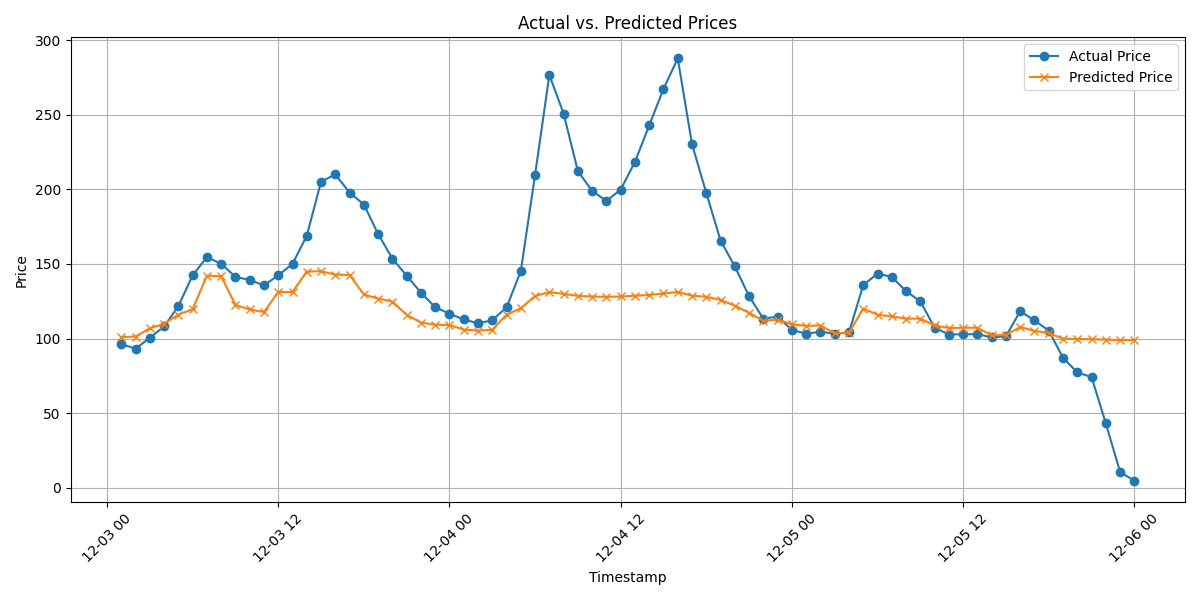

##### Guardian test prediction:
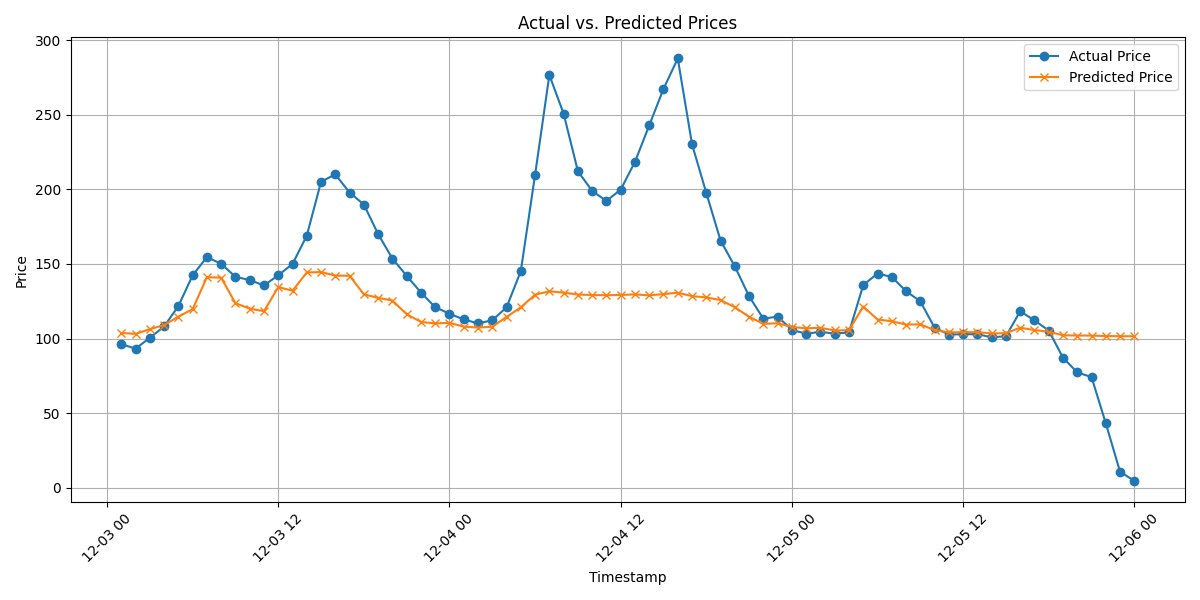

##### Baseline:
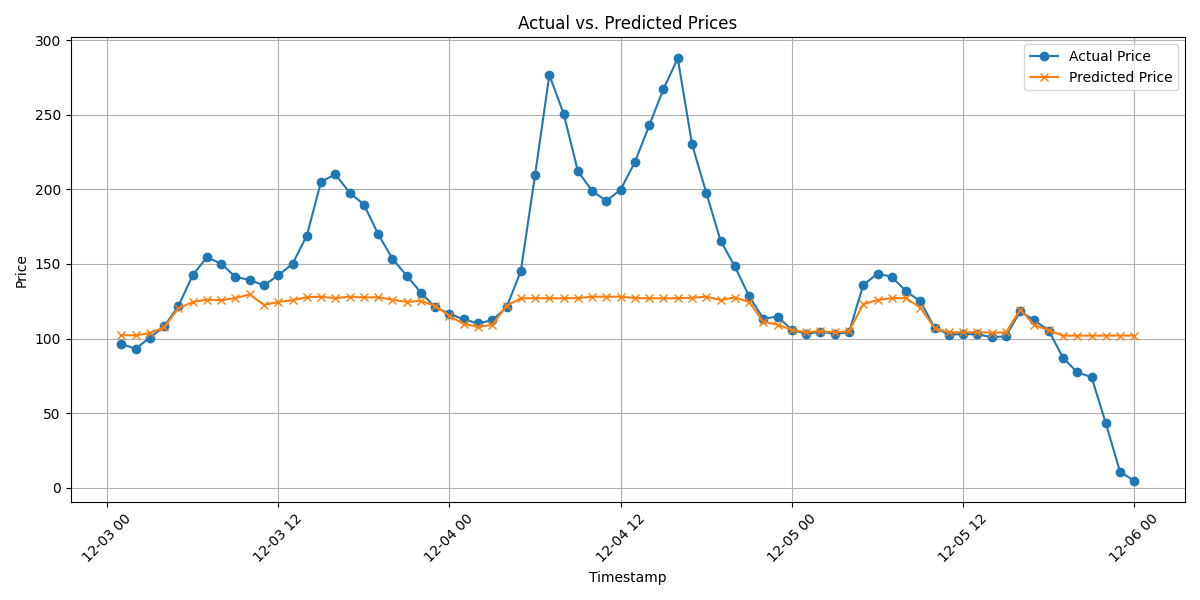

We show that the datasets enhanced with news embeddings outperform the baseline, while there is only a slight difference between the Guardian and NewsAPI embedding performances.
Because of this small difference and the longer available historical data from the Guardians API, we decided to create the full dataset with the Guardian API and compare it to the baseline.

TODO: DL training results & live diagram creation

#### Predicting Intraday-Prices as additional feature

Besides day-ahead prices, which are the target value of this time series forecast, electric energy is also traded on the more short-term Intraday market.
While in general a high correlation of these prices can be assumed, as they refer to the same underlying product, there are cases in which the prices of day-ahead and intraday trades differ significantly, as the intraday market will react more short-term to unforeseen changes in supply and demand.
These short-term differences can for example be induced by
- extreme weather conditions offsetting forecasted and actual generation of renewables affecting supply
- extreme weather conditions generating an unforeseen surge or decline in demand
- unplanned power plant outages creating a lack of supply
- short-term changes in balancing affecting supply

As Germany saw their share of renewables in power generation rise, the role of intraday prices for demand regulation became increasingly important.
Therefore the "gate closure" of intraday trades, meaning the time between end of trading and delivery, got shortened significantly.
In July 2015 it was changed from 45 to 30 minutes, whereas nowadays it's down to 5 minutes, and allows for a high reactivity to changes in supply and demand. [Smard, Großhandelspreise]

Given our time series dataset with all features that resulted from data gathering, we tried to predict the intraday price to use as an additional feature in predicting the day-ahead price.
If we were to predict the intraday prices with high accuracy, this could possibly be an important feature for improving the day-ahead prediction.

Data Sources:
The open data sources for intraday electric energy prices are unfortunately very limited, as in many cases stock market data are sold for commercial data analysis.
"Netztransparenz", which is an information transparency platform by the four German transmission grid operators, publishes a dataset with quarter-hourly intraday price indices from 30th June 2020 to date.
These values are calculated as volume-weighted average of the last stock market orders over 500MW for quarter-hourly electricity.
The dataset of Netztransparenz appears to be the only freely available dataset for German intraday electricity prices.

#TODO Malte

To ensure consistency with the day-ahead price data and to streamline the analysis, the quarter-hourly data was aggregated into hourly values by calculating the mean of the four quarter-hourly values for each hour. This transformation resulted in a more manageable dataset with hourly intraday prices, which were then used for model training and prediction.

The dataset was split into training, validation, and test sets to evaluate the model's performance. The training set comprised 77.34% of the data (29,975 samples), while the validation and test sets each accounted for 11.33% of the data (4,392 samples).

The baseline model was then trained on a simple dataset consisting of the timestamp and the intraday price in euros, with no additional known covariates.

TODO: attach plot
Plot 1 illustrates the performance of the baseline model, showing the discrepancies between predicted and actual intraday prices

To improve upon the baseline model, date-related features were added, including the day of the week, whether the day was a weekend, whether it was a holiday, and the month. These features were included to capture the influence of weekly, seasonal, and holiday-related patterns in energy consumption and prices.

TODO: attach plot
Plot 2 illustrates the performance of the model with date features






## Predictive Modeling

### Final Benchmark

In [ ]:
# ###Load and Execute forecast based on loaded Dataset using pretrained tiny Model.


# model_name = "Chronos"
# model_type = "LSTM"
# target_column = "day_ahead_prices_EURO"
# forecast_results = []


# #Init Model
# model = ChronosModel(model_name=model_name, model_type=model_type)

## model name can be either
## 1. "amazon/tiny" for tine pretrained, not fine-tuned model
## 2. "amazon/large" for large pretrained, not fine-tuned model
## 1. "juliushanusch/chronos-tiny-fine-tuned-day-ahead-prices" for tiny fine-tuned model
## 2. "juliushanusch/chronos-tiny-large-tuned-day-ahead-prices" for large fine-tuned model

#model_name = "juliushanusch/chronos-tiny-fine-tuned-day-ahead-prices"

# model.model = model._BaseModel__custom_load(model_name)

# ####ToDo use actual datafram with day_ahead_pices_Wuro
# data = df4


# data.index = data.index.tz_localize(None)

# # Define forecast date range
# start_forecast_date = pd.Timestamp("2024-06-01 00:00:00").tz_localize(None)
# end_forecast_date = pd.Timestamp("2024-11-30 23:00:00").tz_localize(None)
# forecast_dates = pd.date_range(start_forecast_date, end_forecast_date, freq="D")

# # Collect forecasts
# forecast_results = []

# for forecast_date in forecast_dates:
#     # Determine the end of the context period (1 hour before the forecast date)
#     context_end_date = forecast_date - pd.Timedelta(hours=1)
    
#     # Slice the data to get the context window
#     context_data = data.loc[:context_end_date].iloc[-512:]  # Limit to the last 512 entries
    
#     # Run the forecast for the current date
#     forecast_result = model._BaseModel__run_prediction(context_data)
#     forecast_results.append(forecast_result)

# # Combine all forecast results into a single DataFrame
# all_forecasts = pd.concat(forecast_results, ignore_index=True)

# print(all_forecasts)

### Final Forecast

In [3]:
# TODO Download Up to date Data
# TODO Load best model from disk
# TODO Compute Forecast
# TODO Write to File

## Summary

### Guidance/Planning/Leadership

Team Structure and Initial Organization:
The BTW25 student challenge presented a unique opportunity to work in a large-scale collaborative environment with 12 team members. To effectively manage this substantial team size, we implemented a strategic division into three specialized groups, each focusing on critical aspects of the project:

- XAI and Data Preparation Group: Focused on explainable AI approaches and foundational data analysis
- AutoGluon and Preprocessing Group: Concentrated on implementing solutions using AutoGluon and gathering data
- Deep Learning Models Group: Dedicated to developing complex neural network architectures

Challenges of Interdependent Workflows:
One of the primary challenges we faced was managing the interdependencies between these groups. Each team's output served as essential input for others, creating a complex web of dependencies. For example, the data fetching and preparation team's work directly impacted both the XAIs ability to explore the data and the deep learning team's capacity to develop their architectures. This interconnected structure meant that delays or changes in one group could create ripple effects throughout the entire project.

Cross-Team Communication and Coordination:
To address these challenges, we implemented an "ambassador" system. Members of the AutoGluon team were designated as liaisons to other groups, attending their meetings and serving as communication bridges. This approach proved invaluable for several reasons:

- Real-time awareness of progress and challenges across all teams
- Immediate feedback on compatibility issues between different components
- Rapid dissemination of important updates or changes
- Prevention of duplicate efforts across groups

Standardization and Technical Integration:
A crucial aspect of our success was the implementation of strict technical standards:

Data Format Guidelines:

- Standardized CSV formats for time series data
- Consistent datetime formatting across all datasets
- Uniform naming conventions for features and target variables
- Desired range of data
- Clear separation of train/val/test splits

Model Wrapper Standardization:

- Common interface for all models regardless of underlying implementation
- Standardized prediction output formats
- Unified evaluation metrics and reporting structures

Effective Project Management Practices
To maintain coherence across the large team, we established several key management practices:

- Regular all-hands meetings for high-level coordination
- Dedicated communication channels for each subgroup

Learning Outcomes and Best Practices
This experience provided valuable insights into managing large-scale ML projects:

- The importance of clear communication channels and protocols
- The value of standardized interfaces between different components
- The effectiveness of cross-team ambassadors in maintaining project coherence
- The necessity of flexible yet structured organization in academic projects

Impact on Project Success
These organizational strategies significantly contributed to our project's success by:

- Minimizing integration issues between different components
- Reducing redundant work across teams
- Enabling rapid problem identification and resolution
- Fostering knowledge sharing across specialization boundaries
- Creating a cohesive final product despite the complexity of multiple approaches

The experience demonstrated that effective organization and communication structures are as crucial to project success as technical expertise, particularly in large-scale academic collaborations.


## Future Work

## Conclusion 

## Bibliography
Yun Bai et al., 2024: News and Load: A Quantitative Exploration of Natural Language Processing Applications for Forecasting Day-Ahead Electricity System Demand<br>
Bosch, S., Schlenker, F., Bohn, J., Kupies, S., & Schmidt, M. (2023). Deutschland–Pionierland der Energiewende. In Energie-Weltatlas: Transformation des Energiesystems in globaler Perspektive (pp. 81-91). Wiesbaden: Springer Fachmedien Wiesbaden.
Contreras, J., Espinola, R., Nogales, F. J., & Conejo, A. J. (2003). ARIMA models to predict next-day electricity prices. IEEE transactions on power systems, 18(3), 1014-1020.
Dumancic, M. (2024, March). Marktmacht in der Stromwirtschaft: Mehr Wettbewerb durch Zukunftstechnologien?. In Kartellrecht und Zukunftstechnologien (pp. 105-128). Nomos Verlagsgesellschaft mbH & Co. KG.
Hein, F., & Hermann, H. (2020). Agorameter–Dokumentation. Agora Energiewende: Berlin, Germany.
Lago, J., De Ridder, F., & De Schutter, B. (2018). Forecasting spot electricity prices: Deep learning approaches and empirical comparison of traditional algorithms. Applied Energy, 221, 386-405.
Nestle, D., Ringelstein, J., & Selzam, P. (2009). Integration dezentraler und erneuerbarer Energien durch variable Strompreise im liberalisierten Energiemarkt. uwf UmweltWirtschaftsForum, 17, 361-365.
Niedermeier, T. (2023). Auswertung der Stromerzeugung in Deutschland von 2015–2022 und Abgleich mit den Ausbauzielen des EEG 2023 (Doctoral dissertation, Hochschule für angewandte Wissenschaften München).
Nunes, C., Pacheco, A., & Silva, T. (2008, May). Statistical models to predict electricity prices. In 2008 5th International Conference on the European Electricity Market (pp. 1-6). IEEE.
Ortner, A., & Totschnig, G. (2019). The future relevance of electricity balancing markets in Europe-A 2030 case study. Energy Strategy Reviews, 24, 111-120.
Picasso et al., 2019: Technical analysis and sentiment embeddings for market trend prediction<br>
Schumacher, Ingrid, et al. "Der strommarkt und die strompreisbildung." Strategien zur Strombeschaffung in Unternehmen: Energieeinkauf optimieren, Kosten senken (2015): 9-37.
Tschora, L., Pierre, E., Plantevit, M., & Robardet, C. (2022). Electricity price forecasting on the day-ahead market using machine learning. Applied Energy, 313, 118752.
Smard, Großhandelspreise, 15.12.2024, URL: https://www.smard.de/page/home/wiki-article/446/562<br>
Netztransparenz, Index-Ausgleichspreis, 16.12.2024, URL: https://www.netztransparenz.de/de-de/Regelenergie/Ausgleichsenergiepreis/Index-Ausgleichsenergiepreis<br>
https://www.researchgate.netpublication/348111996_A_Review_on_Linear_Regression_Comprehensive_in_Machine_Learning
-> DOI: http://dx.doi.org/10.38094/jastt1457
comparison of three time series forecasting methods (including linear regression)
->DOI: 10.47738/ijiis.v6i2.165
https://hummedia.manchester.ac.uk/institutes/cmist/archive-publications/working-papers/2008/2008-19-multiple-linear-regression.pdf <br>
Abdul Fatir Ansari et al. 2024: Chronos: Learning the Language of Time Series https://doi.org/10.48550/arXiv.2403.07815<br>
Steinmetz, H., Batzdorfer, V., Scherhag, J., & Bosnjak, M. (2022). The ZPID Lockdown Measures Dataset for Germany [Data set]. PsychArchives. https://doi.org/10.23668/PSYCHARCHIVES.6676<br>